In [124]:
import matplotlib.pyplot as plt
from sympy.plotting import plot as symplot
import numpy as np
import sympy as sym
import math
sym.init_printing()
import pandas as pd
from scipy import stats

In [126]:
#Upper-crust
#(Dry quartz diorite)

In [128]:
f_c = 2.0  # Compression friction coefficient
f_p = 0.35         # Pore fluid pressure factor
rho = 2750       # Density (kg/m^3)
g = 9.81           # Gravity (m/s^2)

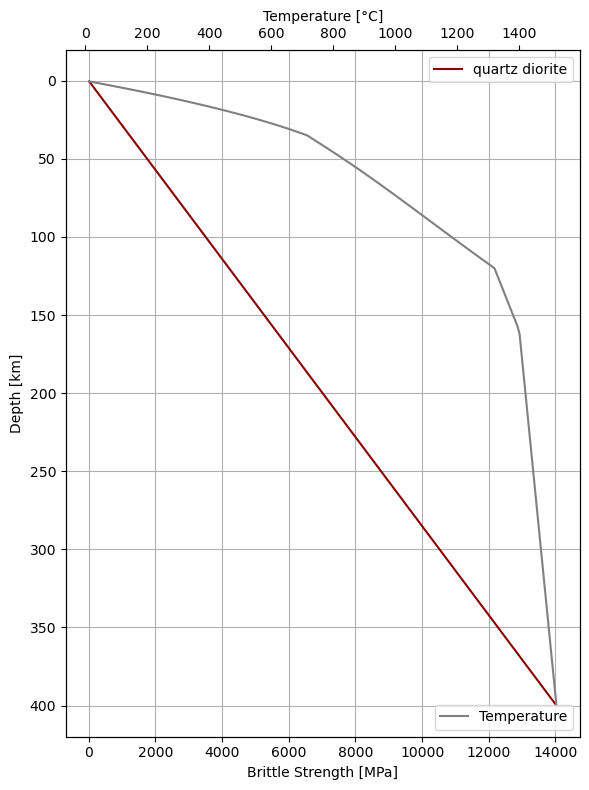

In [130]:

# --- Load data ---
raw_data = np.loadtxt(r'C:\Users\anshu\Desktop\IISER_PUNE_PROJECT\data\post_processing_output_DMM_Afonso.dat')

# Extract depth and temperature (you still need depth from file)
depth_km = -raw_data[:, 1]            # Column 2: depth in km (negative to positive)
depth_m = depth_km * 1000             # Convert to meters
temperature_c = raw_data[:, 2]        # Column 3: temperature in °C
temperature_k = temperature_c + 273.15


# --- Brittle strength calculation using constant rho ---
sigma_brittle_c = f_c * rho * g * depth_m * (1 - f_p)     # in Pascals
sigma_brittle_c_mpa = sigma_brittle_c / 1e6               # convert to MPa

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(sigma_brittle_c_mpa, depth_km, label=r'quartz diorite', color='darkred')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()


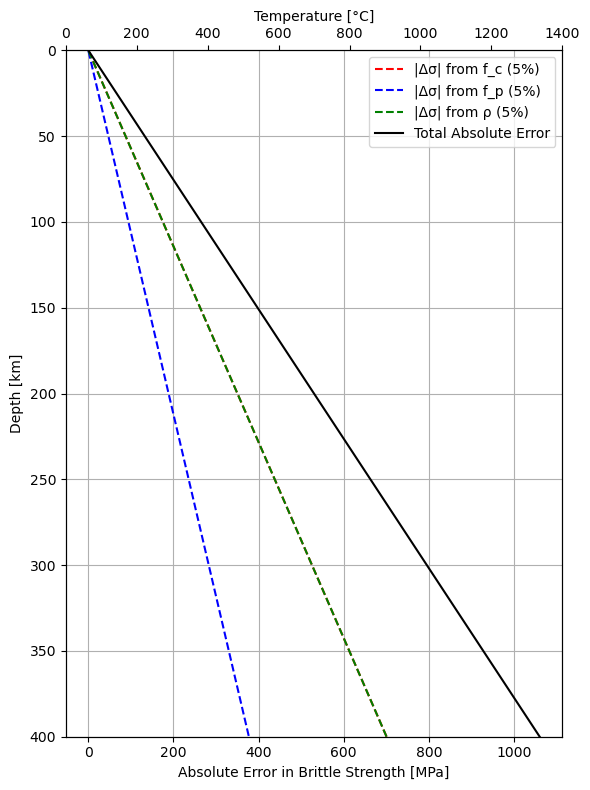

In [131]:
rho = 2750  # kg/m³
f_c_val = 2.0
f_p_val = 0.35
g_val = 9.8  # m/s²

f_c_error = 5     # percent
f_p_error = 5     # percent
rho_error = 5    # percent

# --- Helper: percent → absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Partial derivatives ---
d_sigma_df_c = rho * g_val * depth_m * (1 - f_p_val)
d_sigma_df_p = -f_c_val * rho * g_val * depth_m
d_sigma_drho = f_c_val * g_val * depth_m * (1 - f_p_val)

# --- Absolute parameter errors ---
delta_f_c = error_percentage2value(f_c_val, f_c_error)
delta_f_p = error_percentage2value(f_p_val, f_p_error)
delta_rho = error_percentage2value(rho, rho_error)

# --- Absolute propagated errors ---
error_f_c_abs = np.abs(d_sigma_df_c * delta_f_c)
error_f_p_abs = np.abs(d_sigma_df_p * delta_f_p)
error_rho_abs = np.abs(d_sigma_drho * delta_rho)

# --- Total absolute error (quadratic sum) ---
error_total_abs = np.sqrt(error_f_c_abs**2 + error_f_p_abs**2 + error_rho_abs**2)

# --- Convert all to MPa ---
error_f_c_MPa = error_f_c_abs / 1e6
error_f_p_MPa = error_f_p_abs / 1e6
error_rho_MPa = error_rho_abs / 1e6
error_total_MPa = error_total_abs / 1e6

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(error_f_c_MPa, depth_km, 'r--', label='|Δσ| from f_c (5%)')
ax.plot(error_f_p_MPa, depth_km, 'b--', label='|Δσ| from f_p (5%)')
ax.plot(error_rho_MPa, depth_km, 'g--', label='|Δσ| from ρ (5%)')
ax.plot(error_total_MPa, depth_km, 'k-', label='Total Absolute Error')

ax.set_xlabel('Absolute Error in Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# --- Twin x-axis: Temperature label only ---
ax_temp = ax.twiny()
ax_temp.set_xlim(0, 1400)  # Match temperature range in °C
ax_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

In [133]:
#sigma + delta sigma(absolute error)
sigma_pos=sigma_brittle_c_mpa + error_total_MPa

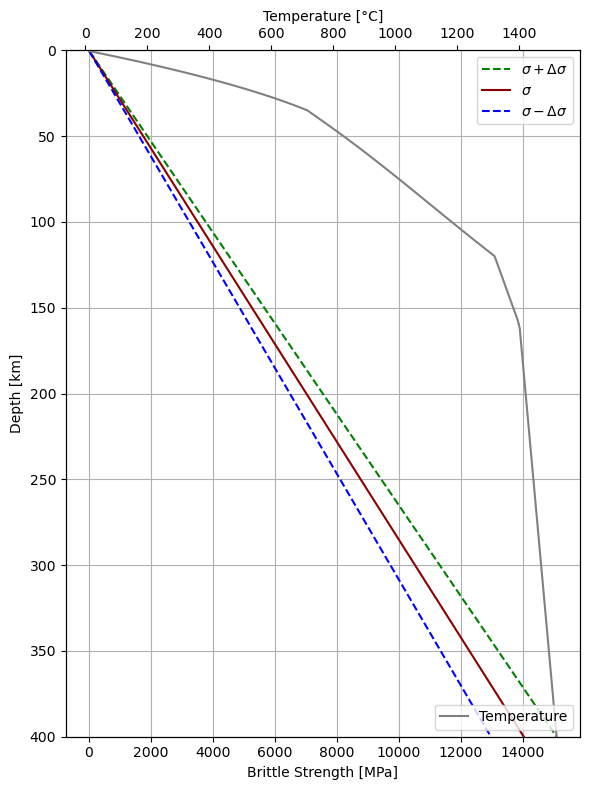

In [136]:
sigma_neg=sigma_brittle_c_mpa - error_total_MPa

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigma_pos, depth_km, 'g--', label=r'$\sigma + \Delta \sigma$')
ax.plot(sigma_brittle_c_mpa, depth_km, label=r'$\sigma$', color='darkred')
ax.plot(sigma_neg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

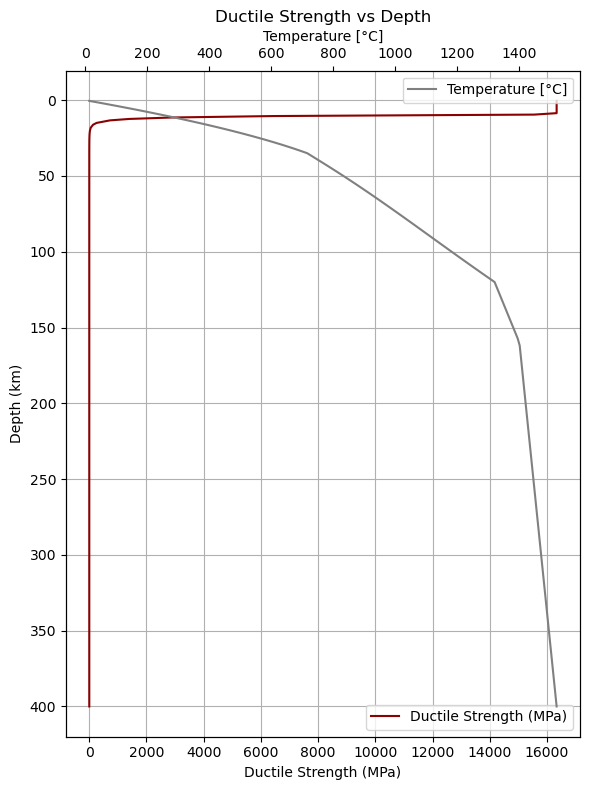

In [137]:
a_p = 5.02e-18 # Increase A to reduce stress
n = 2.4       # Increase n to reduce stress sensitivity
q_p = 2.19e5   # Lower activation energy
strain_rate = 1e-15
R = 8.3144

# Clip temperature below 600°C (873.15 K) to avoid too low T
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# Creep law (dislocation creep)
sigma_disl = ((strain_rate / a_p)** (1 / n) * np.exp(q_p / (R * temp_k_safe*n)))
sigma_ductile_mpa = sigma_disl / 1e6  # Convert to MPa
fig, ax = plt.subplots(figsize=(6, 8))

# Ductile strength plot
ax.plot(sigma_ductile_mpa, depth_km, 'darkred', label='Ductile Strength (MPa)')
ax.invert_yaxis()
ax.set_xlabel('Ductile Strength (MPa)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ductile Strength vs Depth')
ax.grid(True)
ax.legend(loc='lower right')

# Temperature curve
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature [°C]')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='upper right')

plt.tight_layout()
plt.show()


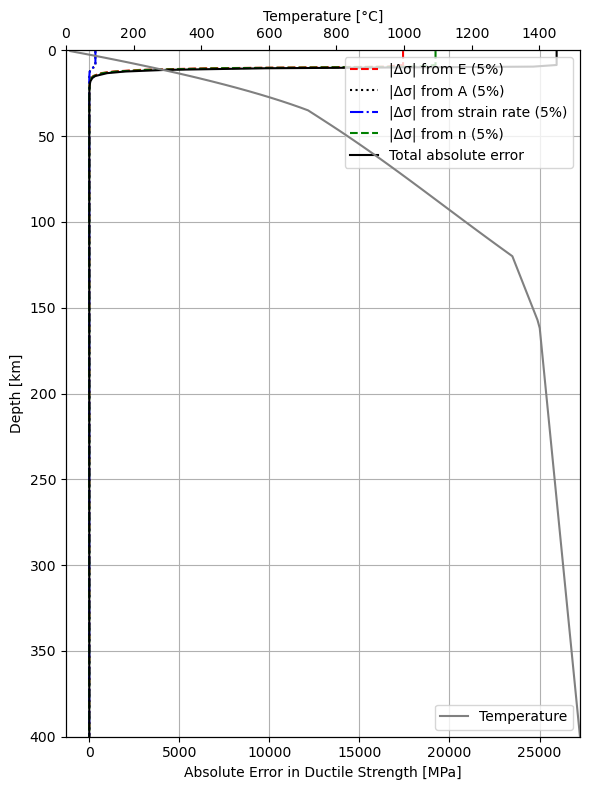

In [139]:
# --- Define symbolic variables ---
T = sym.Symbol('T')  # Temperature [K]
A, E, n, strain_rate, R = sym.symbols('A E n strain_rate R')

# --- Define symbolic expression for dislocation creep ---
sigma_ductile = ((strain_rate / A)** (1 / n) * sym.exp(E / (n* R * T)))   # Pa

# --- Define numerical values ---
A_in = 5.02e-18 # Pa^-n·s^-1
E_in = 2.19e5  # J/mol
n_in = 2.4
S_r_in = 1e-15  # 1/s
R_in = 8.314  # J/mol·K

# temperature_k and depth_km, temperature_c assumed to be defined
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# --- Numerical evaluation function ---
def calc_derivative_geotherm(sigma_expr, T_vals, n_val, A_val, E_val, strain_rate_val, R_val):
    expr_subs = sigma_expr.subs({
        A: A_val,
        E: E_val,
        n: n_val,
        strain_rate: strain_rate_val,
        R: R_val
    }).evalf()
    func = sym.lambdify(T, expr_subs, modules='numpy')
    return func(T_vals)

# --- Convert % error to absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Base strength profile ---
sigma = calc_derivative_geotherm(sigma_ductile, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# --- Derivatives and error propagation ---
E_error = 5
A_error = 5
S_r_error = 5
n_error = 5

# Partial derivatives
Dsigma_DE = sigma_ductile.diff(E)
Dsigma_DA = sigma_ductile.diff(A)
Dsigma_De = sigma_ductile.diff(strain_rate)
Dsigma_Dn = sigma_ductile.diff(n)

# Evaluate partial derivatives numerically
deri_E = calc_derivative_geotherm(Dsigma_DE, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_A = calc_derivative_geotherm(Dsigma_DA, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_S = calc_derivative_geotherm(Dsigma_De, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_n = calc_derivative_geotherm(Dsigma_Dn, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# Compute absolute errors
error_E = np.abs(deri_E * error_percentage2value(E_in, E_error))
error_A = np.abs(deri_A * error_percentage2value(A_in, A_error))
error_S = np.abs(deri_S * error_percentage2value(S_r_in, S_r_error))
error_n = np.abs(deri_n * error_percentage2value(n_in, n_error))

# Total absolute error in [Pa]
error_total = np.sqrt(error_E**2 + error_A**2 + error_S**2 + error_n**2)

# Convert to MPa
sigma_MPa = sigma / 1e6
error_E_MPa = error_E / 1e6
error_A_MPa = error_A / 1e6
error_S_MPa = error_S / 1e6
error_n_MPa = error_n / 1e6
error_total_MPa = error_total / 1e6

# --- Plot error contributions ---
fig, ax_strength = plt.subplots(figsize=(6, 8))

ax_strength.plot(error_E_MPa, depth_km, 'r--', label='|Δσ| from E (5%)')
ax_strength.plot(error_A_MPa, depth_km, 'k:', label='|Δσ| from A (5%)')
ax_strength.plot(error_S_MPa, depth_km, 'b-.', label='|Δσ| from strain rate (5%)')
ax_strength.plot(error_n_MPa, depth_km, 'g--', label='|Δσ| from n (5%)')
ax_strength.plot(error_total_MPa, depth_km, 'black', label='Total absolute error')

ax_strength.set_xlabel('Absolute Error in Ductile Strength [MPa]')
ax_strength.set_ylabel('Depth [km]')
ax_strength.set_ylim(0, np.max(depth_km))
ax_strength.invert_yaxis()
ax_strength.grid(True)
ax_strength.legend(loc='upper right')

# --- Twin x-axis for temperature ---
ax_temp = ax_strength.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.set_xlim(0, np.max(temperature_c))
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [141]:
sigmad_pos=sigma_ductile_mpa + error_total_MPa

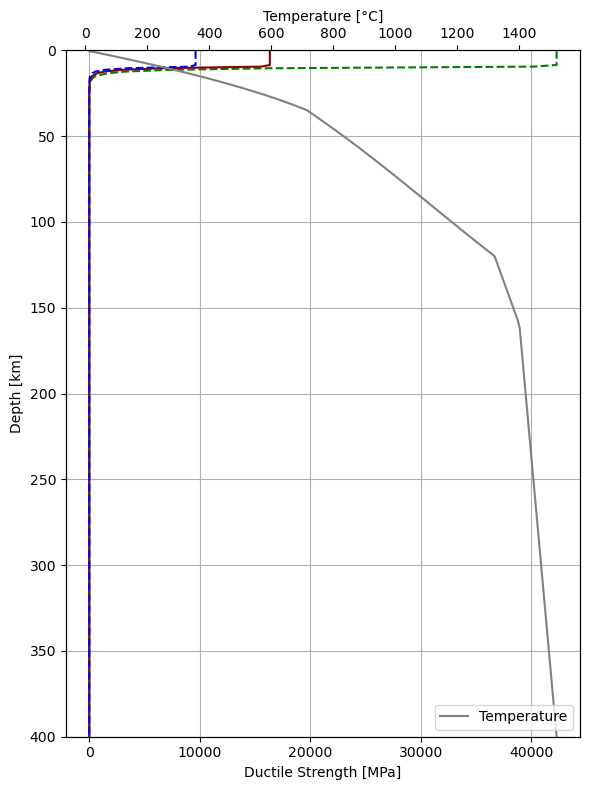

In [144]:
sigmad_neg =np.abs(sigma_ductile_mpa - error_total_MPa )

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigmad_pos, depth_km, 'g--')
ax.plot(sigma_ductile_mpa, depth_km, label=r'$\sigmad$', color='darkred')
ax.plot(sigmad_neg, depth_km, 'b--')
ax.set_xlabel('Ductile Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [146]:
sigma_pos_qd = sigma_pos
sigma_brittle_c_mpa_qd = sigma_brittle_c_mpa
sigma_neg_qd=sigma_neg
sigma_ductile_mpa_qd = sigma_ductile_mpa
sigmad_pos_qd = sigmad_pos
sigmad_neg_qd = sigmad_neg

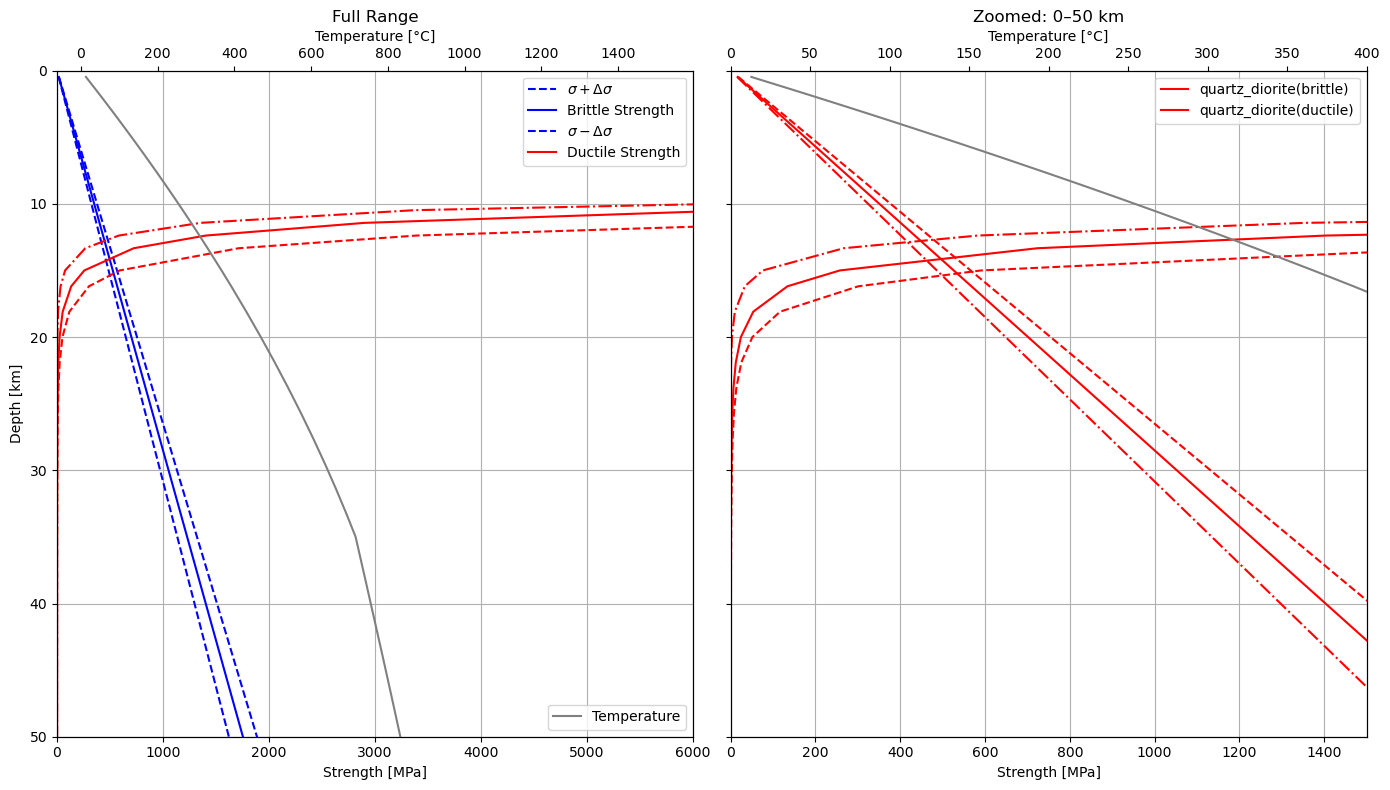

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
# --- Full-range plot ---
ax1.plot(sigma_pos_qd, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qd, depth_km, color='b', label=r'Brittle Strength')
ax1.plot(sigma_neg_qd, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qd, depth_km, 'red', label='Ductile Strength')
ax1.plot(sigmad_pos_qd, depth_km,'--',color='red')
ax1.plot(sigmad_neg_qd, depth_km, '-.',color='red')
ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 6000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
ax2.plot(sigma_pos_qd, depth_km, 'r--')
ax2.plot(sigma_brittle_c_mpa_qd, depth_km, color='red', label='quartz_diorite(brittle)')
ax2.plot(sigma_neg_qd, depth_km, 'r-.')
ax2.plot(sigma_ductile_mpa_qd, depth_km, 'red',label='quartz_diorite(ductile)')
ax2.plot(sigmad_pos_qd, depth_km, '--',color='red')
ax2.plot(sigmad_neg_qd, depth_km, '-.', color='red')
ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 1500)
ax2.set_ylim(50, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


In [150]:
#Sediments
#(Wet Granite5)

In [152]:
f_c = 2.0  # Compression friction coefficient
f_p = 0.35         # Pore fluid pressure factor
rho = 2400      # Density (kg/m^3)
g = 9.81           # Gravity (m/s^2)

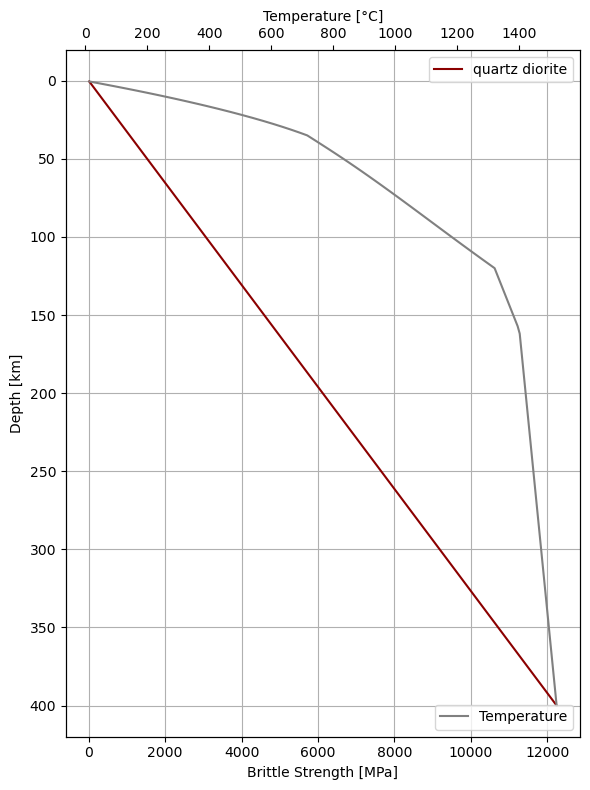

In [156]:

# --- Load data ---
raw_data = np.loadtxt(r'C:\Users\anshu\Desktop\IISER_PUNE_PROJECT\data\post_processing_output_DMM_Afonso.dat')

# Extract depth and temperature (you still need depth from file)
depth_km = -raw_data[:, 1]            # Column 2: depth in km (negative to positive)
depth_m = depth_km * 1000             # Convert to meters
temperature_c = raw_data[:, 2]        # Column 3: temperature in °C
temperature_k = temperature_c + 273.15


# --- Brittle strength calculation using constant rho ---
sigma_brittle_c = f_c * rho * g * depth_m * (1 - f_p)     # in Pascals
sigma_brittle_c_mpa = sigma_brittle_c / 1e6               # convert to MPa

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(sigma_brittle_c_mpa, depth_km, label=r'quartz diorite', color='darkred')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()


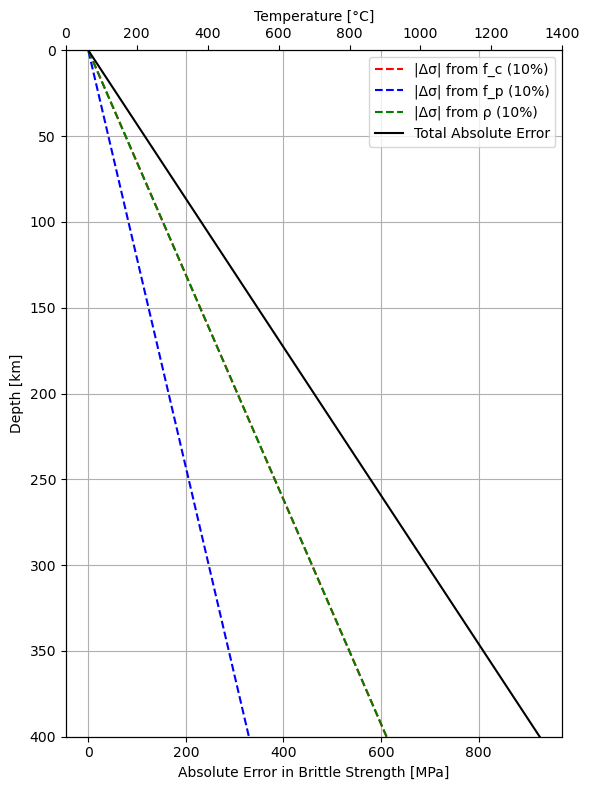

In [158]:
rho = 2400  # kg/m³
f_c_val = 2.0
f_p_val = 0.35
g_val = 9.8  # m/s²

f_c_error = 5    # percent
f_p_error = 5    # percent
rho_error = 5    # percent

# --- Helper: percent → absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Partial derivatives ---
d_sigma_df_c = rho * g_val * depth_m * (1 - f_p_val)
d_sigma_df_p = -f_c_val * rho * g_val * depth_m
d_sigma_drho = f_c_val * g_val * depth_m * (1 - f_p_val)

# --- Absolute parameter errors ---
delta_f_c = error_percentage2value(f_c_val, f_c_error)
delta_f_p = error_percentage2value(f_p_val, f_p_error)
delta_rho = error_percentage2value(rho, rho_error)

# --- Absolute propagated errors ---
error_f_c_abs = np.abs(d_sigma_df_c * delta_f_c)
error_f_p_abs = np.abs(d_sigma_df_p * delta_f_p)
error_rho_abs = np.abs(d_sigma_drho * delta_rho)

# --- Total absolute error (quadratic sum) ---
error_total_abs = np.sqrt(error_f_c_abs**2 + error_f_p_abs**2 + error_rho_abs**2)

# --- Convert all to MPa ---
error_f_c_MPa = error_f_c_abs / 1e6
error_f_p_MPa = error_f_p_abs / 1e6
error_rho_MPa = error_rho_abs / 1e6
error_total_MPa = error_total_abs / 1e6

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(error_f_c_MPa, depth_km, 'r--', label='|Δσ| from f_c (10%)')
ax.plot(error_f_p_MPa, depth_km, 'b--', label='|Δσ| from f_p (10%)')
ax.plot(error_rho_MPa, depth_km, 'g--', label='|Δσ| from ρ (10%)')
ax.plot(error_total_MPa, depth_km, 'k-', label='Total Absolute Error')

ax.set_xlabel('Absolute Error in Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# --- Twin x-axis: Temperature label only ---
ax_temp = ax.twiny()
ax_temp.set_xlim(0, 1400)  # Match temperature range in °C
ax_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

In [160]:
#sigma + delta sigma(absolute error)
sigma_pos=sigma_brittle_c_mpa + error_total_MPa

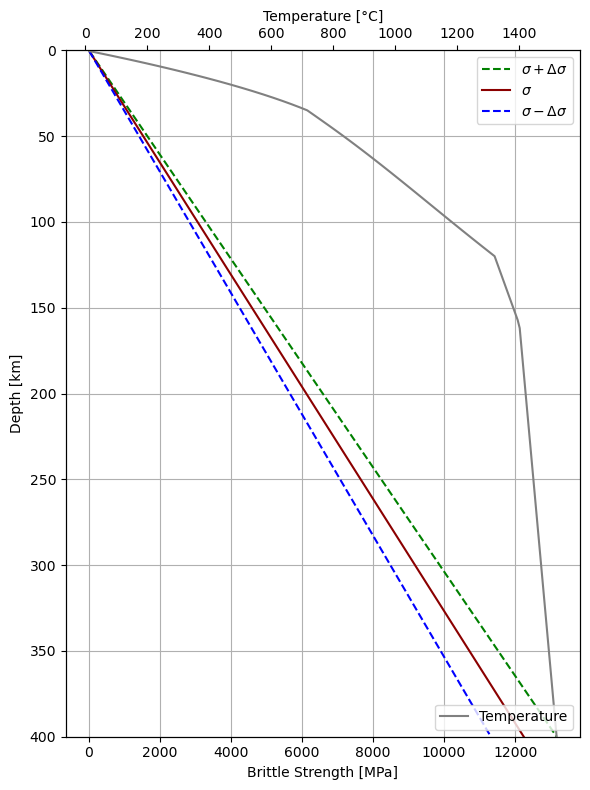

In [162]:
sigma_neg=sigma_brittle_c_mpa - error_total_MPa

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigma_pos, depth_km, 'g--', label=r'$\sigma + \Delta \sigma$')
ax.plot(sigma_brittle_c_mpa, depth_km, label=r'$\sigma$', color='darkred')
ax.plot(sigma_neg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

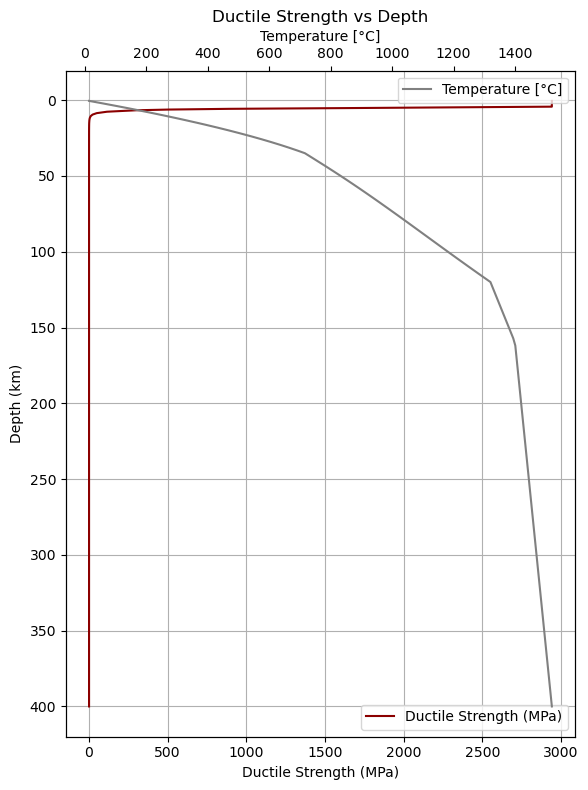

In [174]:
a_p = 7.94e-16 #Power-law strain rate
n = 1.9       # Increase n to reduce stress sensitivity
q_p = 1.37e+05   # Lower activation energy
strain_rate = 1e-15
R = 8.3144

# Clip temperature below 600°C (873.15 K) to avoid too low T
T_min = 400
temp_k_safe = np.clip(temperature_k, T_min, None)

# Creep law (dislocation creep)
sigma_disl = ((strain_rate / a_p)** (1 / n) * np.exp(q_p / (R * temp_k_safe*n)))
sigma_ductile_mpa = sigma_disl / 1e6  # Convert to MPa
fig, ax = plt.subplots(figsize=(6, 8))

# Ductile strength plot
ax.plot(sigma_ductile_mpa, depth_km, 'darkred', label='Ductile Strength (MPa)')
ax.invert_yaxis()
ax.set_xlabel('Ductile Strength (MPa)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ductile Strength vs Depth')
ax.grid(True)
ax.legend(loc='lower right')

# Temperature curve
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature [°C]')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='upper right')

plt.tight_layout()
plt.show()


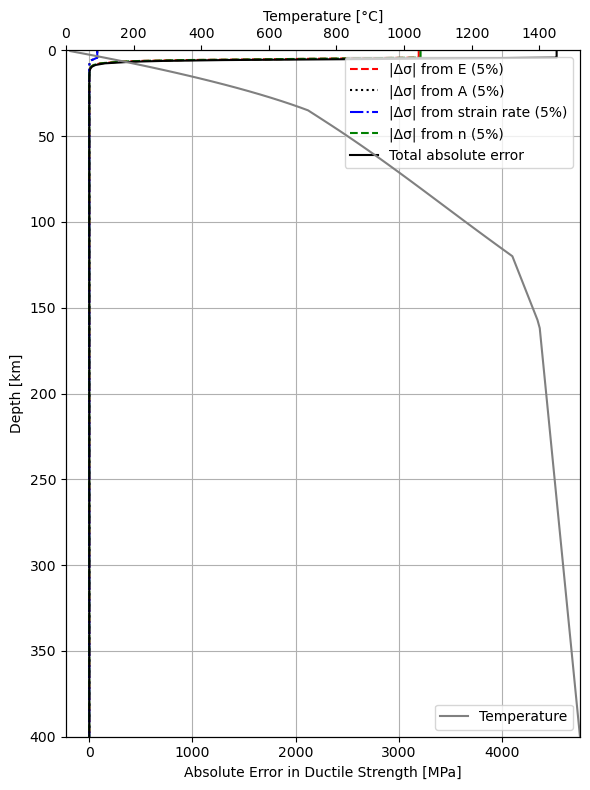

In [178]:
# --- Define symbolic variables ---
T = sym.Symbol('T')  # Temperature [K]
A, E, n, strain_rate, R = sym.symbols('A E n strain_rate R')

# --- Define symbolic expression for dislocation creep ---
sigma_ductile = ((strain_rate / A)** (1 / n) * sym.exp(E / (n* R * T)))   # Pa

# --- Define numerical values ---
A_in = 7.94e-16 # Pa^-n·s^-1
E_in = 1.37e+05 # J/mol
n_in = 1.9 
S_r_in = 1e-15  # 1/s
R_in = 8.314  # J/mol·K

# temperature_k and depth_km, temperature_c assumed to be defined
T_min = 400
temp_k_safe = np.clip(temperature_k, T_min, None)

# --- Numerical evaluation function ---
def calc_derivative_geotherm(sigma_expr, T_vals, n_val, A_val, E_val, strain_rate_val, R_val):
    expr_subs = sigma_expr.subs({
        A: A_val,
        E: E_val,
        n: n_val,
        strain_rate: strain_rate_val,
        R: R_val
    }).evalf()
    func = sym.lambdify(T, expr_subs, modules='numpy')
    return func(T_vals)

# --- Convert % error to absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Base strength profile ---
sigma = calc_derivative_geotherm(sigma_ductile, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# --- Derivatives and error propagation ---
E_error = 5
A_error =5
S_r_error = 5
n_error = 5

# Partial derivatives
Dsigma_DE = sigma_ductile.diff(E)
Dsigma_DA = sigma_ductile.diff(A)
Dsigma_De = sigma_ductile.diff(strain_rate)
Dsigma_Dn = sigma_ductile.diff(n)

# Evaluate partial derivatives numerically
deri_E = calc_derivative_geotherm(Dsigma_DE, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_A = calc_derivative_geotherm(Dsigma_DA, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_S = calc_derivative_geotherm(Dsigma_De, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_n = calc_derivative_geotherm(Dsigma_Dn, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# Compute absolute errors
error_E = np.abs(deri_E * error_percentage2value(E_in, E_error))
error_A = np.abs(deri_A * error_percentage2value(A_in, A_error))
error_S = np.abs(deri_S * error_percentage2value(S_r_in, S_r_error))
error_n = np.abs(deri_n * error_percentage2value(n_in, n_error))

# Total absolute error in [Pa]
error_total = np.sqrt(error_E**2 + error_A**2 + error_S**2 + error_n**2)

# Convert to MPa
sigma_MPa = sigma / 1e6
error_E_MPa = error_E / 1e6
error_A_MPa = error_A / 1e6
error_S_MPa = error_S / 1e6
error_n_MPa = error_n / 1e6
error_total_MPa = error_total / 1e6

# --- Plot error contributions ---
fig, ax_strength = plt.subplots(figsize=(6, 8))

ax_strength.plot(error_E_MPa, depth_km, 'r--', label='|Δσ| from E (5%)')
ax_strength.plot(error_A_MPa, depth_km, 'k:', label='|Δσ| from A (5%)')
ax_strength.plot(error_S_MPa, depth_km, 'b-.', label='|Δσ| from strain rate (5%)')
ax_strength.plot(error_n_MPa, depth_km, 'g--', label='|Δσ| from n (5%)')
ax_strength.plot(error_total_MPa, depth_km, 'black', label='Total absolute error')

ax_strength.set_xlabel('Absolute Error in Ductile Strength [MPa]')
ax_strength.set_ylabel('Depth [km]')
ax_strength.set_ylim(0, np.max(depth_km))
ax_strength.invert_yaxis()
ax_strength.grid(True)
ax_strength.legend(loc='upper right')

# --- Twin x-axis for temperature ---
ax_temp = ax_strength.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.set_xlim(0, np.max(temperature_c))
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

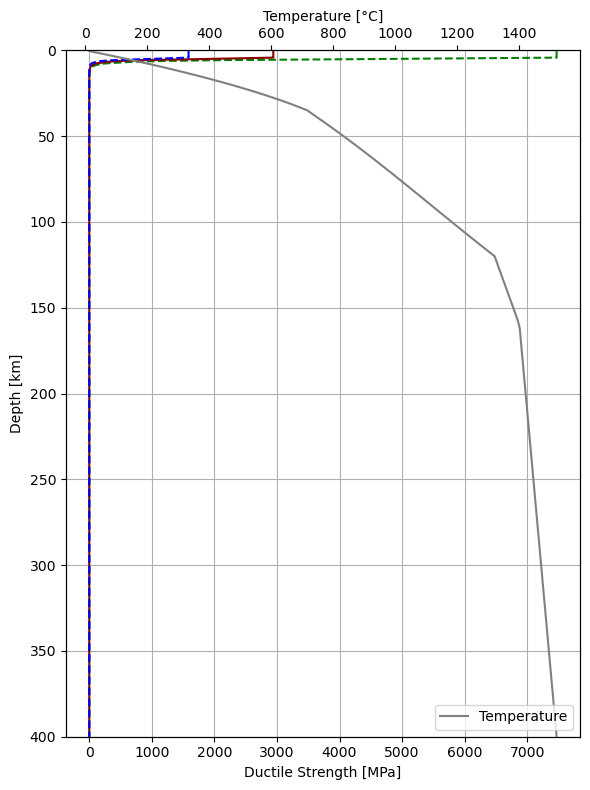

In [180]:
sigmad_pos=sigma_ductile_mpa + error_total_MPa
sigmad_neg =np.abs(sigma_ductile_mpa - error_total_MPa )

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigmad_pos, depth_km, 'g--')
ax.plot(sigma_ductile_mpa, depth_km, label=r'$\sigmad$', color='darkred')
ax.plot(sigmad_neg, depth_km, 'b--')
ax.set_xlabel('Ductile Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [182]:
sigma_pos_wg=sigma_pos
sigma_brittle_c_mpa_wg = sigma_brittle_c_mpa
sigma_neg_wg = sigma_neg
sigma_ductile_mpa_wg = sigma_ductile_mpa
sigmad_pos_wg = sigmad_pos
sigmad_neg_wg = sigmad_neg

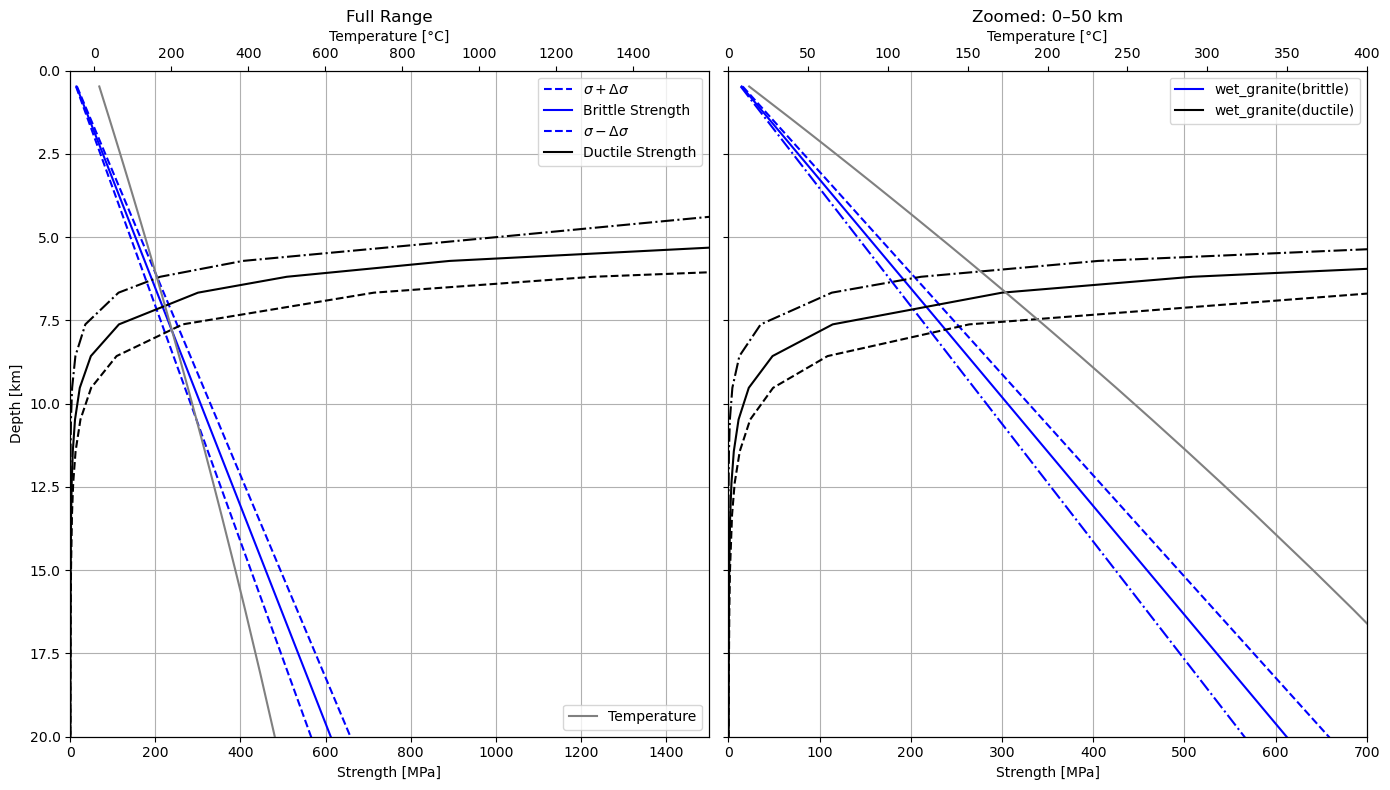

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# --- Full-range plot ---
ax1.plot(sigma_pos_wg, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_wg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_wg, depth_km, 'black', label='Ductile Strength')
ax1.plot(sigmad_pos_wg, depth_km,'--',color='black')
ax1.plot(sigmad_neg_wg, depth_km, '-.',color='black')
ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 1500)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
ax2.plot(sigma_pos_wg, depth_km, 'b--')
ax2.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label='wet_granite(brittle)')
ax2.plot(sigma_neg_wg, depth_km, 'b-.')
ax2.plot(sigma_ductile_mpa_wg, depth_km, 'black',label='wet_granite(ductile)')
ax2.plot(sigmad_pos_wg, depth_km, '--',color='black')
ax2.plot(sigmad_neg_wg, depth_km, '-.', color='black')
ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 700)
ax2.set_ylim(20, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


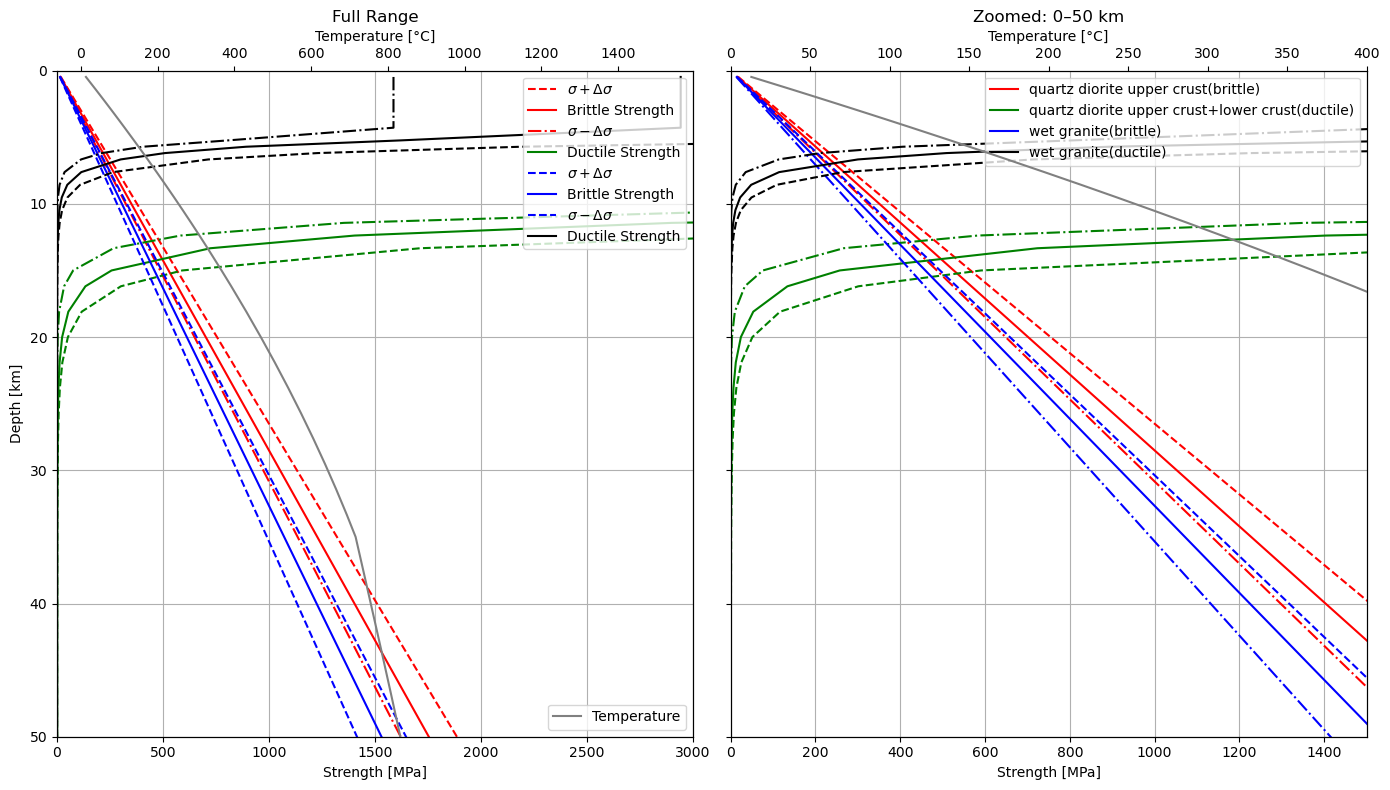

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# --- Full-range plot ---
ax1.plot(sigma_pos_qd, depth_km, '--',color='red', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qd, depth_km, color='red', label=r'Brittle Strength')
ax1.plot(sigma_neg_qd, depth_km, '-.',color = 'red',  label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='Ductile Strength')
ax1.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax1.plot(sigmad_neg_qd, depth_km, '-.',color='green')

ax1.plot(sigma_pos_wg, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_wg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_wg, depth_km, 'black', label='Ductile Strength')
ax1.plot(sigmad_pos_wg, depth_km,'--',color='black')
ax1.plot(sigmad_neg_wg, depth_km, '-.',color='black')
ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 3000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
ax2.plot(sigma_pos_qd, depth_km, '--',color='red')
ax2.plot(sigma_brittle_c_mpa_qd, depth_km, color='red',label='quartz diorite upper crust(brittle)')
ax2.plot(sigma_neg_qd, depth_km, '-.',color = 'red')
ax2.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='quartz diorite upper crust+lower crust(ductile)')
ax2.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax2.plot(sigmad_neg_qd, depth_km, '-.',color='green') 

ax2.plot(sigma_pos, depth_km, 'b--')
ax2.plot(sigma_brittle_c_mpa, depth_km, color='blue', label='wet granite(brittle)')
ax2.plot(sigma_neg, depth_km, 'b-.')
ax2.plot(sigma_ductile_mpa, depth_km, 'black',label='wet granite(ductile)')
ax2.plot(sigmad_pos, depth_km, '--',color='black')
ax2.plot(sigmad_neg, depth_km, '-.', color='black')
ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 1500)
ax2.set_ylim(50, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


In [198]:
#Middle-crust 
#(Dry quartz diorite)

In [200]:
f_c = 2.0  # Compression friction coefficient
f_p = 0.35         # Pore fluid pressure factor
rho = 2850       # Density (kg/m^3)
g = 9.81           # Gravity (m/s^2)

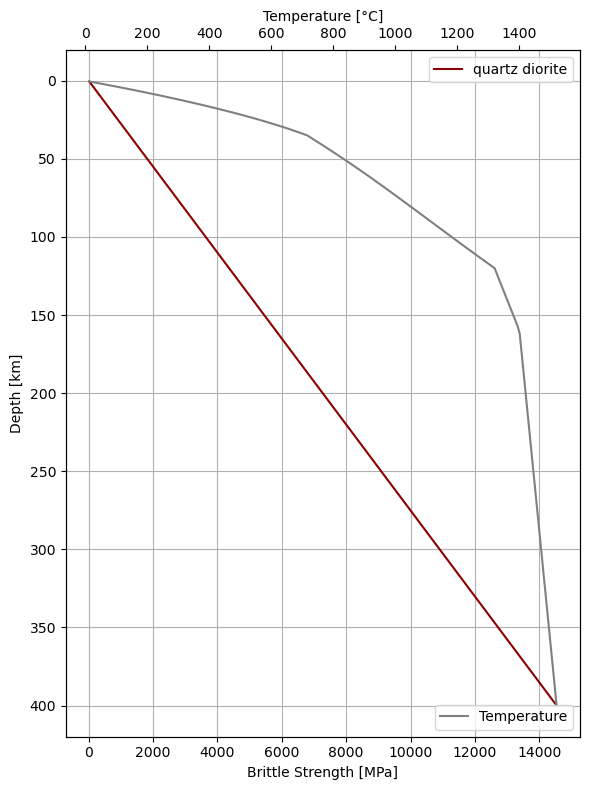

In [204]:

# --- Load data ---
raw_data = np.loadtxt(r'C:\Users\anshu\Desktop\IISER_PUNE_PROJECT\data\post_processing_output_DMM_Afonso.dat')

# Extract depth and temperature (you still need depth from file)
depth_km = -raw_data[:, 1]            # Column 2: depth in km (negative to positive)
depth_m = depth_km * 1000             # Convert to meters
temperature_c = raw_data[:, 2]        # Column 3: temperature in °C
temperature_k = temperature_c + 273.15


# --- Brittle strength calculation using constant rho ---
sigma_brittle_c = f_c * rho * g * depth_m * (1 - f_p)     # in Pascals
sigma_brittle_c_mpa = sigma_brittle_c / 1e6               # convert to MPa

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(sigma_brittle_c_mpa, depth_km, label=r'quartz diorite', color='darkred')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()


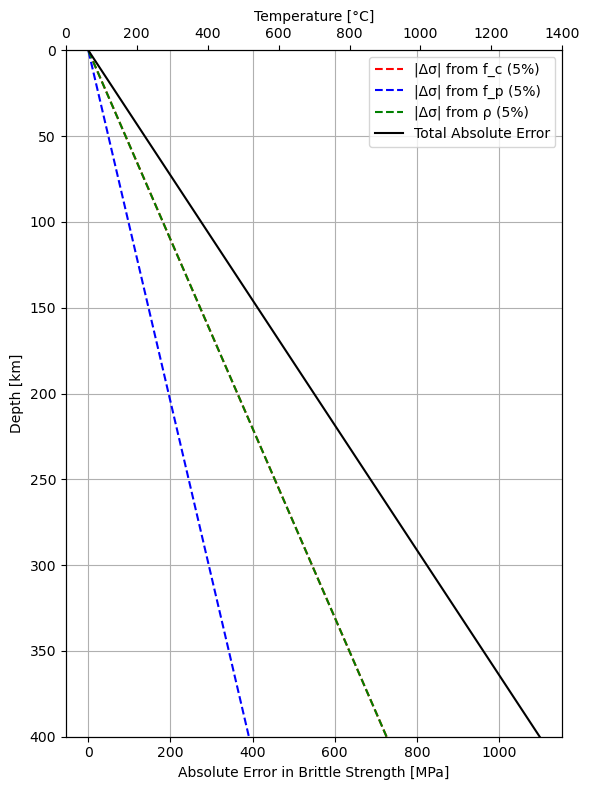

In [206]:
rho = 2850  # kg/m³
f_c_val = 2.0
f_p_val = 0.35
g_val = 9.8  # m/s²

f_c_error = 5    # percent
f_p_error = 5     # percent
rho_error = 5    # percent

# --- Helper: percent → absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Partial derivatives ---
d_sigma_df_c = rho * g_val * depth_m * (1 - f_p_val)
d_sigma_df_p = -f_c_val * rho * g_val * depth_m
d_sigma_drho = f_c_val * g_val * depth_m * (1 - f_p_val)

# --- Absolute parameter errors ---
delta_f_c = error_percentage2value(f_c_val, f_c_error)
delta_f_p = error_percentage2value(f_p_val, f_p_error)
delta_rho = error_percentage2value(rho, rho_error)

# --- Absolute propagated errors ---
error_f_c_abs = np.abs(d_sigma_df_c * delta_f_c)
error_f_p_abs = np.abs(d_sigma_df_p * delta_f_p)
error_rho_abs = np.abs(d_sigma_drho * delta_rho)

# --- Total absolute error (quadratic sum) ---
error_total_abs = np.sqrt(error_f_c_abs**2 + error_f_p_abs**2 + error_rho_abs**2)

# --- Convert all to MPa ---
error_f_c_MPa = error_f_c_abs / 1e6
error_f_p_MPa = error_f_p_abs / 1e6
error_rho_MPa = error_rho_abs / 1e6
error_total_MPa = error_total_abs / 1e6

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(error_f_c_MPa, depth_km, 'r--', label='|Δσ| from f_c (5%)')
ax.plot(error_f_p_MPa, depth_km, 'b--', label='|Δσ| from f_p (5%)')
ax.plot(error_rho_MPa, depth_km, 'g--', label='|Δσ| from ρ (5%)')
ax.plot(error_total_MPa, depth_km, 'k-', label='Total Absolute Error')

ax.set_xlabel('Absolute Error in Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# --- Twin x-axis: Temperature label only ---
ax_temp = ax.twiny()
ax_temp.set_xlim(0, 1400)  # Match temperature range in °C
ax_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

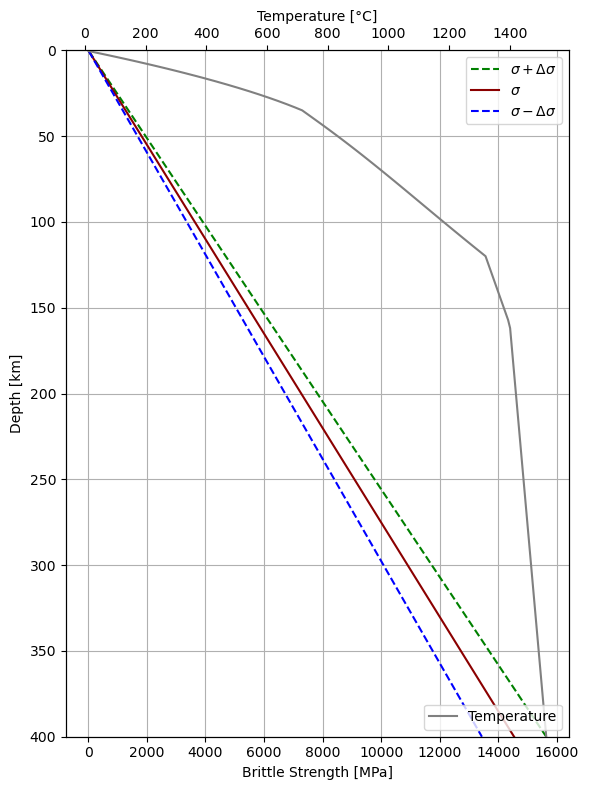

In [208]:
#sigma + delta sigma(absolute error)
sigma_pos=sigma_brittle_c_mpa + error_total_MPa
sigma_neg=sigma_brittle_c_mpa - error_total_MPa

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigma_pos, depth_km, 'g--', label=r'$\sigma + \Delta \sigma$')
ax.plot(sigma_brittle_c_mpa, depth_km, label=r'$\sigma$', color='darkred')
ax.plot(sigma_neg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [210]:
sigma_pos_qdm=sigma_pos
sigma_neg_qdm=sigma_neg
sigma_brittle_c_mpa_qdm=sigma_brittle_c_mpa

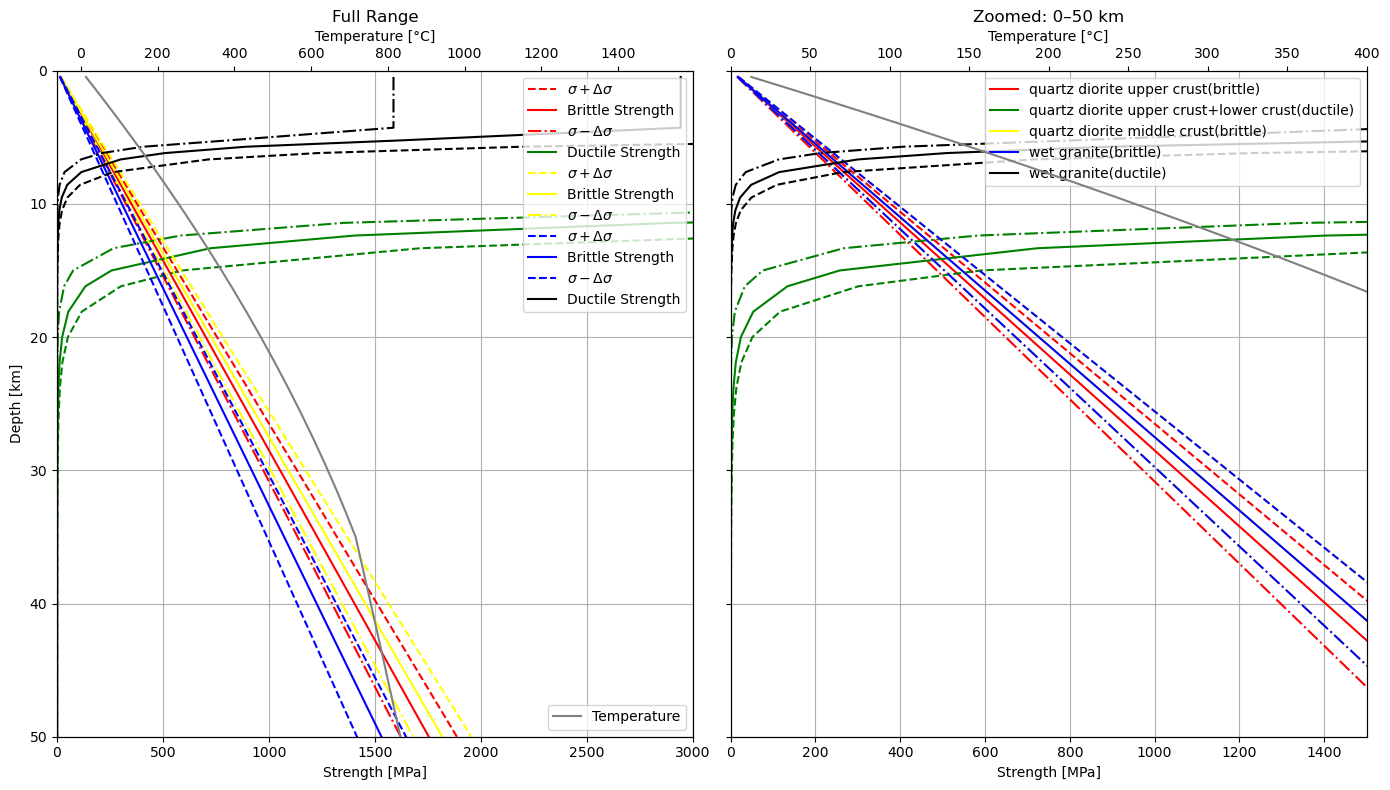

In [214]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

#quartz diorite plot
ax1.plot(sigma_pos_qd, depth_km, '--',color='red', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qd, depth_km, color='red', label=r'Brittle Strength')
ax1.plot(sigma_neg_qd, depth_km, '-.',color = 'red',  label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='Ductile Strength')
ax1.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax1.plot(sigmad_neg_qd, depth_km, '-.',color='green')

ax1.plot(sigma_pos_qdm, depth_km, '--',color='yellow', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'Brittle Strength')
ax1.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow',  label=r'$\sigma - \Delta \sigma$')
#wet granite plot
ax1.plot(sigma_pos_wg, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_wg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_wg, depth_km, 'black', label='Ductile Strength')
ax1.plot(sigmad_pos_wg, depth_km,'--',color='black')
ax1.plot(sigmad_neg_wg, depth_km, '-.',color='black')

ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 3000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
ax2.plot(sigma_pos_qd, depth_km, '--',color='red')
ax2.plot(sigma_brittle_c_mpa_qd, depth_km, color='red',label='quartz diorite upper crust(brittle)')
ax2.plot(sigma_neg_qd, depth_km, '-.',color = 'red')
ax2.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='quartz diorite upper crust+lower crust(ductile)')
ax2.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax2.plot(sigmad_neg_qd, depth_km, '-.',color='green')

ax2.plot(sigma_pos_qdm, depth_km, '--',color='yellow')
ax2.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'quartz diorite middle crust(brittle)')
ax2.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow')
#wet granite
ax2.plot(sigma_pos, depth_km, 'b--')
ax2.plot(sigma_brittle_c_mpa, depth_km, color='blue', label='wet granite(brittle)')
ax2.plot(sigma_neg, depth_km, 'b-.')
ax2.plot(sigma_ductile_mpa, depth_km, 'black',label='wet granite(ductile)')
ax2.plot(sigmad_pos, depth_km, '--',color='black')
ax2.plot(sigmad_neg, depth_km, '-.', color='black')
ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 1500)
ax2.set_ylim(50, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


In [216]:
#Lower-crust
#(Dry mafic granulite)

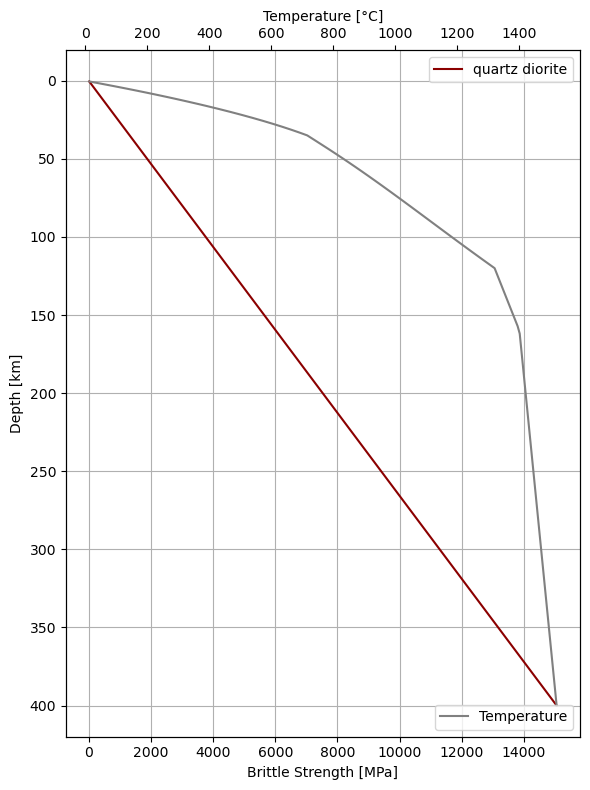

In [218]:
f_c = 2.0  # Compression friction coefficient
f_p = 0.35         # Pore fluid pressure factor
rho = 2950       # Density (kg/m^3)
g = 9.81           # Gravity (m/s^2)

# --- Load data ---
raw_data = np.loadtxt(r'C:\Users\anshu\Desktop\IISER_PUNE_PROJECT\data\post_processing_output_DMM_Afonso.dat')

# Extract depth and temperature (you still need depth from file)
depth_km = -raw_data[:, 1]            # Column 2: depth in km (negative to positive)
depth_m = depth_km * 1000             # Convert to meters
temperature_c = raw_data[:, 2]        # Column 3: temperature in °C
temperature_k = temperature_c + 273.15


# --- Brittle strength calculation using constant rho ---
sigma_brittle_c = f_c * rho * g * depth_m * (1 - f_p)     # in Pascals
sigma_brittle_c_mpa = sigma_brittle_c / 1e6               # convert to MPa

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(sigma_brittle_c_mpa, depth_km, label=r'quartz diorite', color='darkred')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()


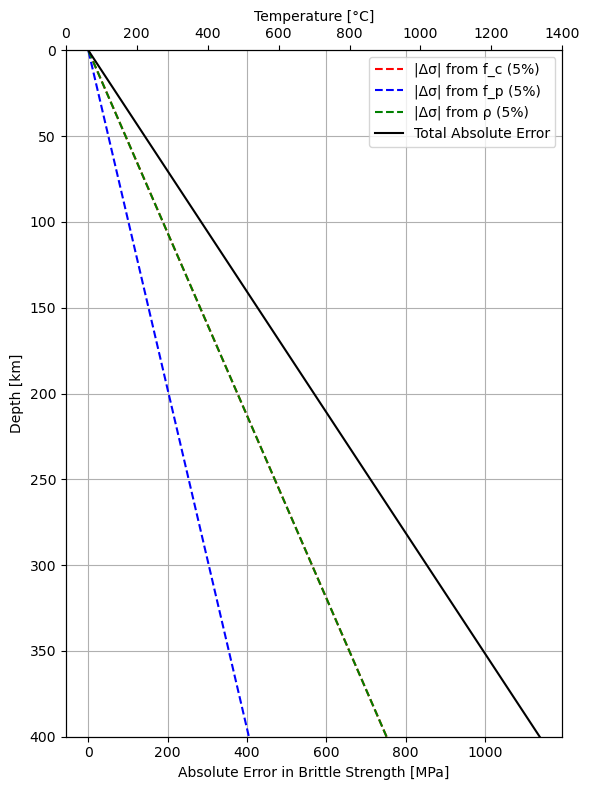

In [220]:
rho = 2950  # kg/m³
f_c_val = 2.0
f_p_val = 0.35
g_val = 9.8  # m/s²

f_c_error = 5     # percent
f_p_error = 5     # percent
rho_error = 5    # percent

# --- Helper: percent → absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Partial derivatives ---
d_sigma_df_c = rho * g_val * depth_m * (1 - f_p_val)
d_sigma_df_p = -f_c_val * rho * g_val * depth_m
d_sigma_drho = f_c_val * g_val * depth_m * (1 - f_p_val)

# --- Absolute parameter errors ---
delta_f_c = error_percentage2value(f_c_val, f_c_error)
delta_f_p = error_percentage2value(f_p_val, f_p_error)
delta_rho = error_percentage2value(rho, rho_error)

# --- Absolute propagated errors ---
error_f_c_abs = np.abs(d_sigma_df_c * delta_f_c)
error_f_p_abs = np.abs(d_sigma_df_p * delta_f_p)
error_rho_abs = np.abs(d_sigma_drho * delta_rho)

# --- Total absolute error (quadratic sum) ---
error_total_abs = np.sqrt(error_f_c_abs**2 + error_f_p_abs**2 + error_rho_abs**2)

# --- Convert all to MPa ---
error_f_c_MPa = error_f_c_abs / 1e6
error_f_p_MPa = error_f_p_abs / 1e6
error_rho_MPa = error_rho_abs / 1e6
error_total_MPa = error_total_abs / 1e6

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(error_f_c_MPa, depth_km, 'r--', label='|Δσ| from f_c (5%)')
ax.plot(error_f_p_MPa, depth_km, 'b--', label='|Δσ| from f_p (5%)')
ax.plot(error_rho_MPa, depth_km, 'g--', label='|Δσ| from ρ (5%)')
ax.plot(error_total_MPa, depth_km, 'k-', label='Total Absolute Error')

ax.set_xlabel('Absolute Error in Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# --- Twin x-axis: Temperature label only ---
ax_temp = ax.twiny()
ax_temp.set_xlim(0, 1400)  # Match temperature range in °C
ax_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

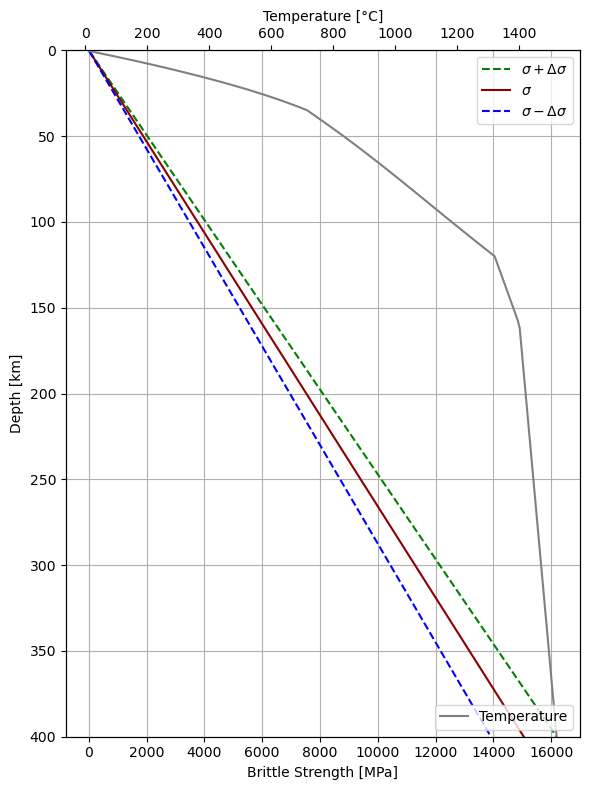

In [222]:
#sigma + delta sigma(absolute error)
sigma_pos=sigma_brittle_c_mpa + error_total_MPa
sigma_neg=sigma_brittle_c_mpa - error_total_MPa

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigma_pos, depth_km, 'g--', label=r'$\sigma + \Delta \sigma$')
ax.plot(sigma_brittle_c_mpa, depth_km, label=r'$\sigma$', color='darkred')
ax.plot(sigma_neg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

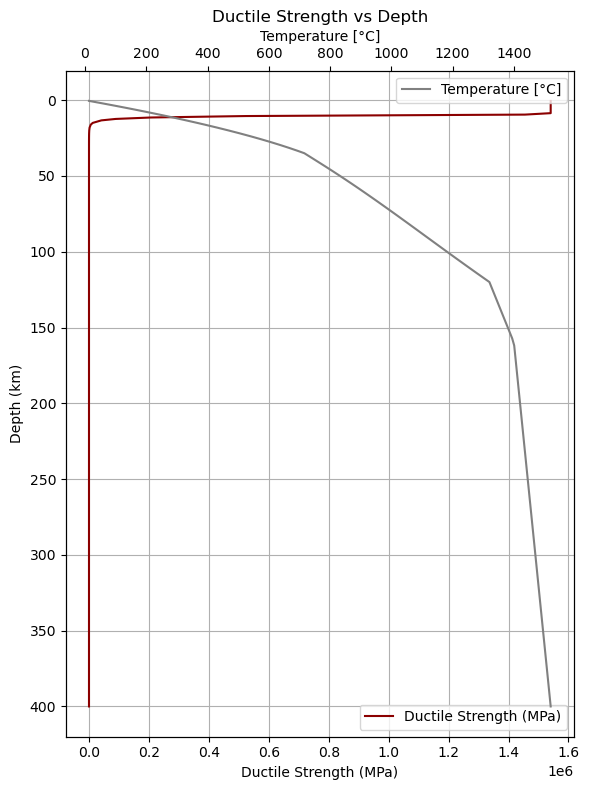

In [224]:
a_p = 8.83e-22 #Power-law strain rate
n = 4.2      # Increase n to reduce stress sensitivity
q_p = 4.45e+05  # Lower activation energy
strain_rate = 1e-15
R = 8.3144

# Clip temperature below 600°C (873.15 K) to avoid too low T
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# Creep law (dislocation creep)
sigma_disl = ((strain_rate / a_p)** (1 / n) * np.exp(q_p / (R * temp_k_safe*n)))
sigma_ductile_mpa = sigma_disl / 1e6  # Convert to MPa
fig, ax = plt.subplots(figsize=(6, 8))

# Ductile strength plot
ax.plot(sigma_ductile_mpa, depth_km, 'darkred', label='Ductile Strength (MPa)')
ax.invert_yaxis()
ax.set_xlabel('Ductile Strength (MPa)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ductile Strength vs Depth')
ax.grid(True)
ax.legend(loc='lower right')

# Temperature curve
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature [°C]')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='upper right')

plt.tight_layout()
plt.show()


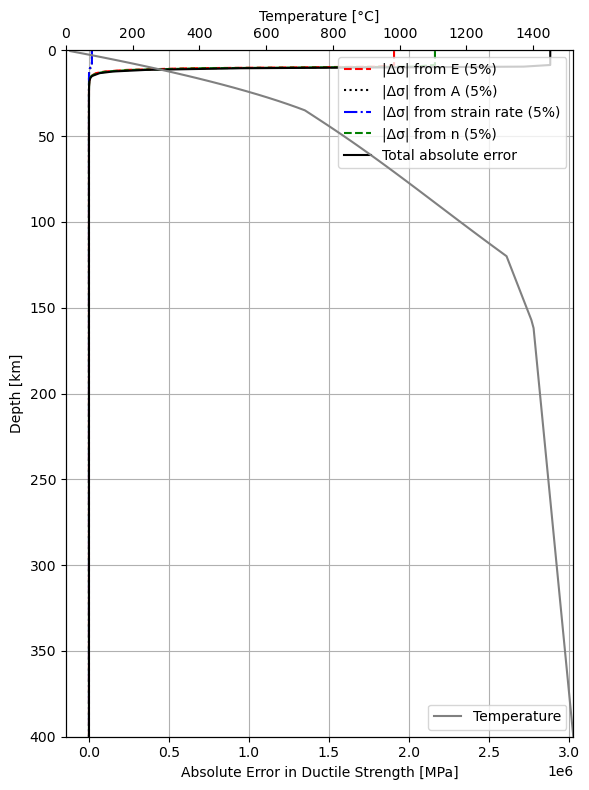

In [226]:
# --- Define symbolic variables ---
T = sym.Symbol('T')  # Temperature [K]
A, E, n, strain_rate, R = sym.symbols('A E n strain_rate R')

# --- Define symbolic expression for dislocation creep ---
sigma_ductile = ((strain_rate / A)** (1 / n) * sym.exp(E / (n* R * T)))   # Pa

# --- Define numerical values ---
A_in = 8.83e-22 # Pa^-n·s^-1
E_in = 4.45e+05 # J/mol
n_in = 4.2
S_r_in = 1e-15  # 1/s
R_in = 8.314  # J/mol·K

# temperature_k and depth_km, temperature_c assumed to be defined
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# --- Numerical evaluation function ---
def calc_derivative_geotherm(sigma_expr, T_vals, n_val, A_val, E_val, strain_rate_val, R_val):
    expr_subs = sigma_expr.subs({
        A: A_val,
        E: E_val,
        n: n_val,
        strain_rate: strain_rate_val,
        R: R_val
    }).evalf()
    func = sym.lambdify(T, expr_subs, modules='numpy')
    return func(T_vals)

# --- Convert % error to absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Base strength profile ---
sigma = calc_derivative_geotherm(sigma_ductile, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# --- Derivatives and error propagation ---
E_error = 5
A_error = 5
S_r_error = 5
n_error = 5

# Partial derivatives
Dsigma_DE = sigma_ductile.diff(E)
Dsigma_DA = sigma_ductile.diff(A)
Dsigma_De = sigma_ductile.diff(strain_rate)
Dsigma_Dn = sigma_ductile.diff(n)

# Evaluate partial derivatives numerically
deri_E = calc_derivative_geotherm(Dsigma_DE, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_A = calc_derivative_geotherm(Dsigma_DA, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_S = calc_derivative_geotherm(Dsigma_De, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_n = calc_derivative_geotherm(Dsigma_Dn, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# Compute absolute errors
error_E = np.abs(deri_E * error_percentage2value(E_in, E_error))
error_A = np.abs(deri_A * error_percentage2value(A_in, A_error))
error_S = np.abs(deri_S * error_percentage2value(S_r_in, S_r_error))
error_n = np.abs(deri_n * error_percentage2value(n_in, n_error))

# Total absolute error in [Pa]
error_total = np.sqrt(error_E**2 + error_A**2 + error_S**2 + error_n**2)

# Convert to MPa
sigma_MPa = sigma / 1e6
error_E_MPa = error_E / 1e6
error_A_MPa = error_A / 1e6
error_S_MPa = error_S / 1e6
error_n_MPa = error_n / 1e6
error_total_MPa = error_total / 1e6

# --- Plot error contributions ---
fig, ax_strength = plt.subplots(figsize=(6, 8))

ax_strength.plot(error_E_MPa, depth_km, 'r--', label='|Δσ| from E (5%)')
ax_strength.plot(error_A_MPa, depth_km, 'k:', label='|Δσ| from A (5%)')
ax_strength.plot(error_S_MPa, depth_km, 'b-.', label='|Δσ| from strain rate (5%)')
ax_strength.plot(error_n_MPa, depth_km, 'g--', label='|Δσ| from n (5%)')
ax_strength.plot(error_total_MPa, depth_km, 'black', label='Total absolute error')

ax_strength.set_xlabel('Absolute Error in Ductile Strength [MPa]')
ax_strength.set_ylabel('Depth [km]')
ax_strength.set_ylim(0, np.max(depth_km))
ax_strength.invert_yaxis()
ax_strength.grid(True)
ax_strength.legend(loc='upper right')

# --- Twin x-axis for temperature ---
ax_temp = ax_strength.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.set_xlim(0, np.max(temperature_c))
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

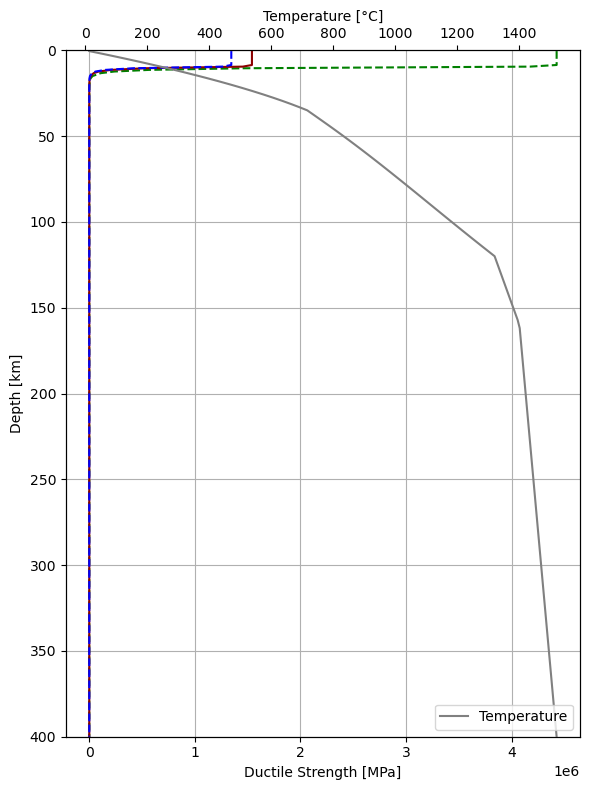

In [228]:
#sigma + delta sigma(absolute error)
sigmad_pos=sigma_ductile_mpa + error_total_MPa
sigmad_neg = np.abs(sigma_ductile_mpa - error_total_MPa )

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigmad_pos, depth_km, 'g--')
ax.plot(sigma_ductile_mpa, depth_km, label=r'$\sigmad$', color='darkred')
ax.plot(sigmad_neg, depth_km, 'b--')
ax.set_xlabel('Ductile Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [230]:
sigma_pos_qm= sigma_pos
sigma_brittle_c_mpa_qm = sigma_brittle_c_mpa
sigma_neg_qm = sigma_neg
sigma_ductile_mpa_qm = sigma_ductile_mpa
sigmad_pos_qm = sigmad_pos
sigmad_neg_qm = sigmad_neg

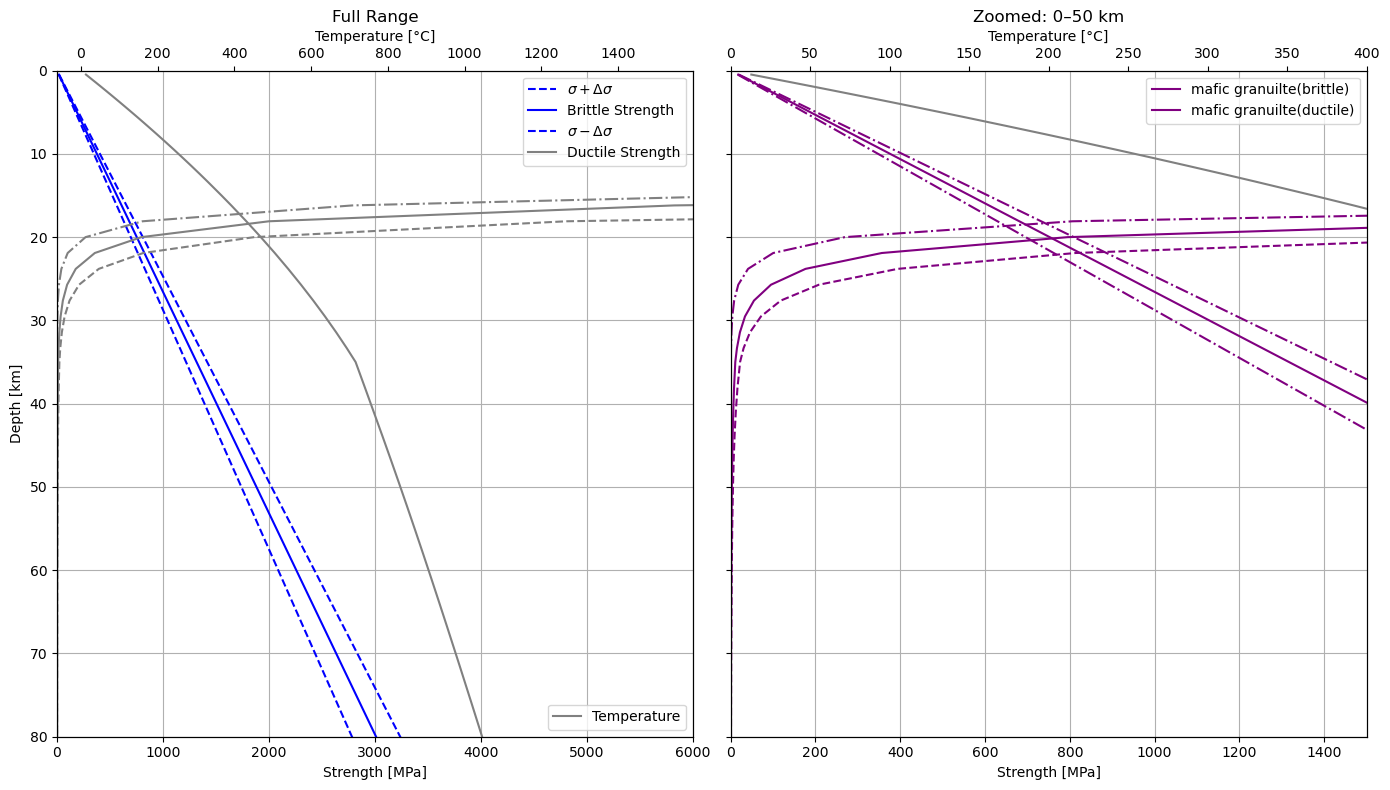

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
#mafic granuilite
ax1.plot(sigma_pos_qm, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qm, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_qm, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qm, depth_km, 'grey', label='Ductile Strength')
ax1.plot(sigmad_pos_qm, depth_km,'--',color='grey')
ax1.plot(sigmad_neg_qm, depth_km, '-.',color='grey')
ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 6000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

ax2.plot(sigma_pos_qm, depth_km, '-.' ,color='purple')
ax2.plot(sigma_brittle_c_mpa_qm, depth_km, color='purple', label=r'mafic granuilte(brittle)')
ax2.plot(sigma_neg_qm, depth_km, '-.', color='purple')
ax2.plot(sigma_ductile_mpa_qm, depth_km, 'purple', label='mafic granuilte(ductile)')
ax2.plot(sigmad_pos_qm, depth_km,'--',color='purple')
ax2.plot(sigmad_neg_qm, depth_km, '-.',color='purple')

ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 1500)
ax2.set_ylim(80, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

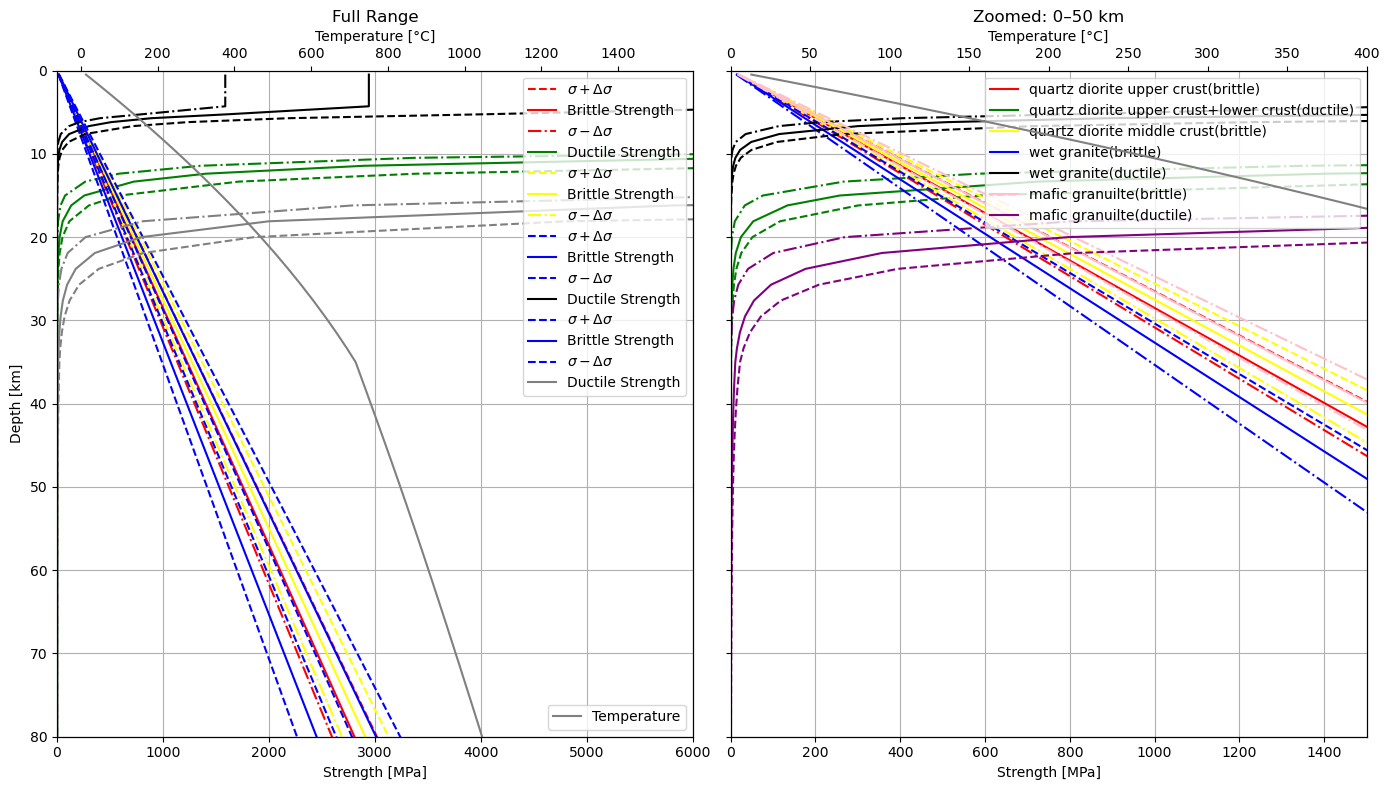

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

#quartz diorite plot
ax1.plot(sigma_pos_qd, depth_km, '--',color='red', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qd, depth_km, color='red', label=r'Brittle Strength')
ax1.plot(sigma_neg_qd, depth_km, '-.',color = 'red',  label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='Ductile Strength')
ax1.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax1.plot(sigmad_neg_qd, depth_km, '-.',color='green')
#miidle crust
ax1.plot(sigma_pos_qdm, depth_km, '--',color='yellow', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'Brittle Strength')
ax1.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow',  label=r'$\sigma - \Delta \sigma$')
#wet granite plot
ax1.plot(sigma_pos_wg, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_wg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_wg, depth_km, 'black', label='Ductile Strength')
ax1.plot(sigmad_pos_wg, depth_km,'--',color='black')
ax1.plot(sigmad_neg_wg, depth_km, '-.',color='black')
#mafic granuilite
ax1.plot(sigma_pos_qm, depth_km, 'b--', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qm, depth_km, color='blue', label=r'Brittle Strength')
ax1.plot(sigma_neg_qm, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qm, depth_km, 'grey', label='Ductile Strength')
ax1.plot(sigmad_pos_qm, depth_km,'--',color='grey')
ax1.plot(sigmad_neg_qm, depth_km, '-.',color='grey')

ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 6000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
ax2.plot(sigma_pos_qd, depth_km, '--',color='red')
ax2.plot(sigma_brittle_c_mpa_qd, depth_km, color='red',label='quartz diorite upper crust(brittle)')
ax2.plot(sigma_neg_qd, depth_km, '-.',color = 'red')
ax2.plot(sigma_ductile_mpa_qd, depth_km, 'green', label='quartz diorite upper crust+lower crust(ductile)')
ax2.plot(sigmad_pos_qd, depth_km,'--',color='green')
ax2.plot(sigmad_neg_qd, depth_km, '-.',color='green')

ax2.plot(sigma_pos_qdm, depth_km, '--',color='yellow')
ax2.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'quartz diorite middle crust(brittle)')
ax2.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow')
#wet granite
ax2.plot(sigma_pos_wg, depth_km, 'b--')
ax2.plot(sigma_brittle_c_mpa_wg, depth_km, color='blue', label='wet granite(brittle)')
ax2.plot(sigma_neg_wg, depth_km, 'b-.')
ax2.plot(sigma_ductile_mpa_wg, depth_km, 'black',label='wet granite(ductile)')
ax2.plot(sigmad_pos_wg, depth_km, '--',color='black')
ax2.plot(sigmad_neg_wg, depth_km, '-.', color='black')
#granulite
ax2.plot(sigma_pos_qm, depth_km, '-.' ,color='pink')
ax2.plot(sigma_brittle_c_mpa_qm, depth_km, color='pink', label=r'mafic granuilte(brittle)')
ax2.plot(sigma_neg_qm, depth_km, '-.', color='pink')
ax2.plot(sigma_ductile_mpa_qm, depth_km, 'purple', label='mafic granuilte(ductile)')
ax2.plot(sigmad_pos_qm, depth_km,'--',color='purple')
ax2.plot(sigmad_neg_qm, depth_km, '-.',color='purple')

ax2.legend(loc='upper right')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 1500)
ax2.set_ylim(80, 0)
ax2.grid(True)
ax2.set_title('Zoomed: 0–50 km')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


In [240]:
#Mantle
#(Dry peridotite56)

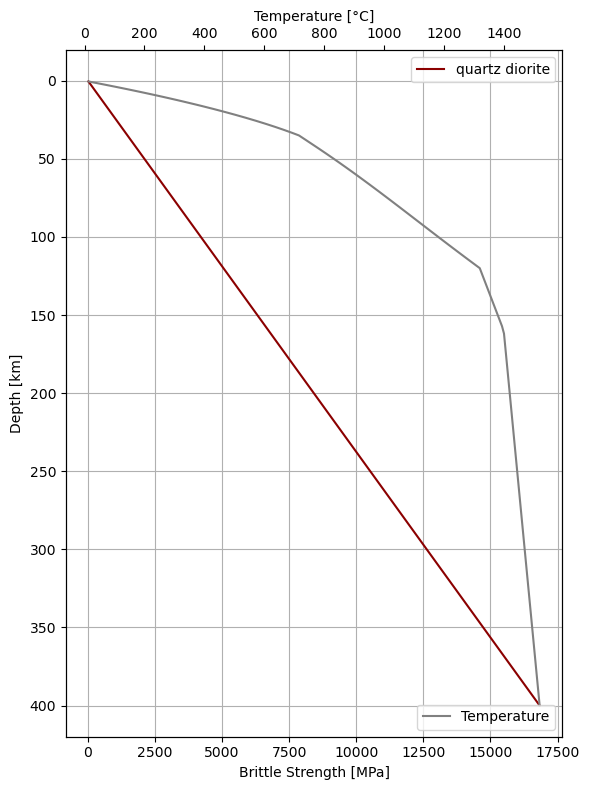

In [244]:
f_c = 2.0  # Compression friction coefficient
f_p = 0.35         # Pore fluid pressure factor
rho = 3300       # Density (kg/m^3)
g = 9.81           # Gravity (m/s^2)

# --- Load data ---
raw_data = np.loadtxt(r'C:\Users\anshu\Desktop\IISER_PUNE_PROJECT\data\post_processing_output_DMM_Afonso.dat')

# Extract depth and temperature (you still need depth from file)
depth_km = -raw_data[:, 1]            # Column 2: depth in km (negative to positive)
depth_m = depth_km * 1000             # Convert to meters
temperature_c = raw_data[:, 2]        # Column 3: temperature in °C
temperature_k = temperature_c + 273.15


# --- Brittle strength calculation using constant rho ---
sigma_brittle_c = f_c * rho * g * depth_m * (1 - f_p)     # in Pascals
sigma_brittle_c_mpa = sigma_brittle_c / 1e6               # convert to MPa

# --- Plotting ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(sigma_brittle_c_mpa, depth_km, label=r'quartz diorite', color='darkred')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()


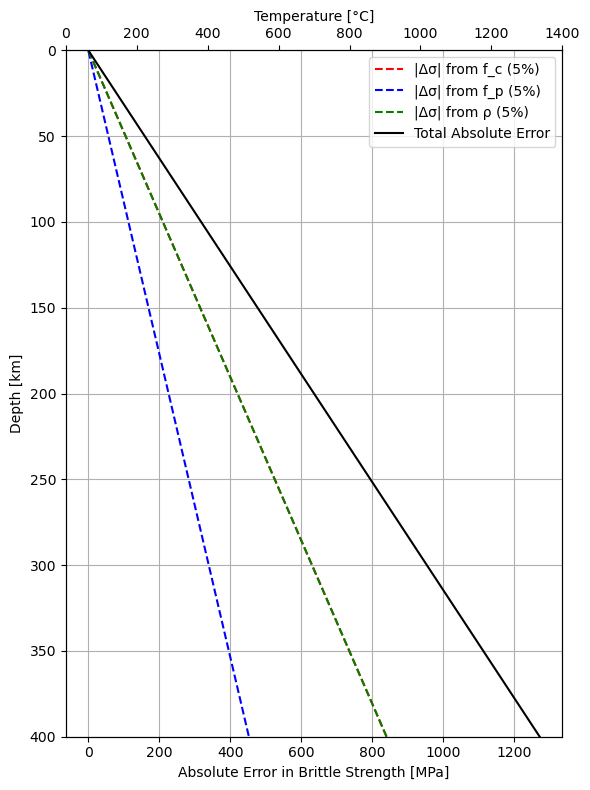

In [246]:
rho = 3300  # kg/m³
f_c_val = 2.0
f_p_val = 0.35
g_val = 9.8  # m/s²

f_c_error = 5    # percent
f_p_error = 5     # percent
rho_error = 5    # percent

# --- Helper: percent → absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Partial derivatives ---
d_sigma_df_c = rho * g_val * depth_m * (1 - f_p_val)
d_sigma_df_p = -f_c_val * rho * g_val * depth_m
d_sigma_drho = f_c_val * g_val * depth_m * (1 - f_p_val)

# --- Absolute parameter errors ---
delta_f_c = error_percentage2value(f_c_val, f_c_error)
delta_f_p = error_percentage2value(f_p_val, f_p_error)
delta_rho = error_percentage2value(rho, rho_error)

# --- Absolute propagated errors ---
error_f_c_abs = np.abs(d_sigma_df_c * delta_f_c)
error_f_p_abs = np.abs(d_sigma_df_p * delta_f_p)
error_rho_abs = np.abs(d_sigma_drho * delta_rho)

# --- Total absolute error (quadratic sum) ---
error_total_abs = np.sqrt(error_f_c_abs**2 + error_f_p_abs**2 + error_rho_abs**2)

# --- Convert all to MPa ---
error_f_c_MPa = error_f_c_abs / 1e6
error_f_p_MPa = error_f_p_abs / 1e6
error_rho_MPa = error_rho_abs / 1e6
error_total_MPa = error_total_abs / 1e6

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 8))

ax.plot(error_f_c_MPa, depth_km, 'r--', label='|Δσ| from f_c (5%)')
ax.plot(error_f_p_MPa, depth_km, 'b--', label='|Δσ| from f_p (5%)')
ax.plot(error_rho_MPa, depth_km, 'g--', label='|Δσ| from ρ (5%)')
ax.plot(error_total_MPa, depth_km, 'k-', label='Total Absolute Error')

ax.set_xlabel('Absolute Error in Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# --- Twin x-axis: Temperature label only ---
ax_temp = ax.twiny()
ax_temp.set_xlim(0, 1400)  # Match temperature range in °C
ax_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()

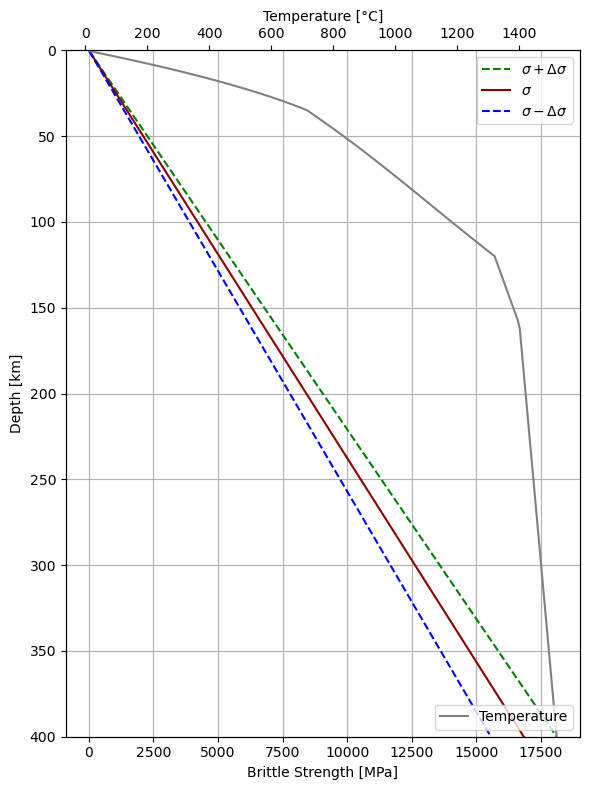

In [248]:
#sigma + delta sigma(absolute error)
sigma_pos=sigma_brittle_c_mpa + error_total_MPa
sigma_neg=sigma_brittle_c_mpa - error_total_MPa

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigma_pos, depth_km, 'g--', label=r'$\sigma + \Delta \sigma$')
ax.plot(sigma_brittle_c_mpa, depth_km, label=r'$\sigma$', color='darkred')
ax.plot(sigma_neg, depth_km, 'b--', label=r'$\sigma - \Delta \sigma$')
ax.set_xlabel('Brittle Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.grid(True)
ax.legend(loc='upper right')

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

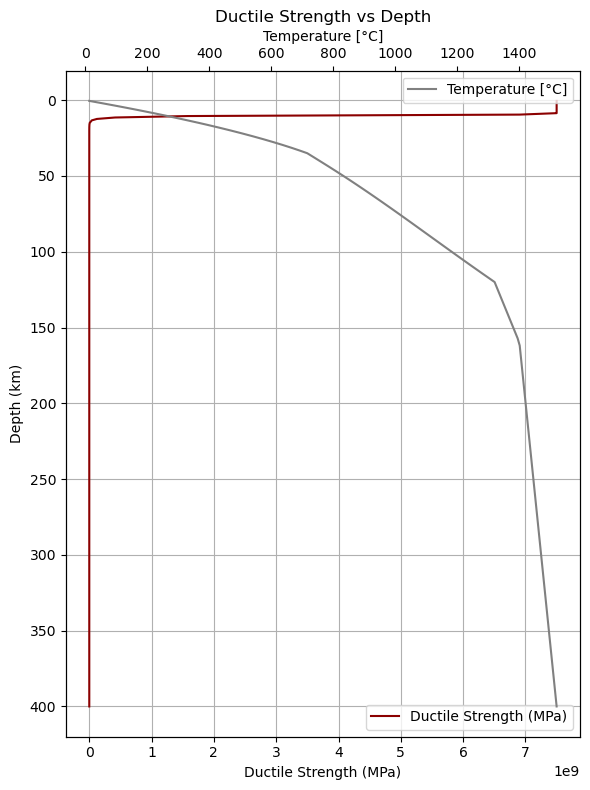

In [250]:
a_p = 5.01e-17 #Power-law strain rate
n = 3.5      # Increase n to reduce stress sensitivity
q_p = 5.35e+05 # Lower activation energy
strain_rate = 1e-15
R = 8.3144

# Clip temperature below 600°C (873.15 K) to avoid too low T
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# Creep law (dislocation creep)
sigma_disl = ((strain_rate / a_p)** (1 / n) * np.exp(q_p / (R * temp_k_safe*n)))
sigma_ductile_mpa = sigma_disl / 1e6  # Convert to MPa
fig, ax = plt.subplots(figsize=(6, 8))

# Ductile strength plot
ax.plot(sigma_ductile_mpa, depth_km, 'darkred', label='Ductile Strength (MPa)')
ax.invert_yaxis()
ax.set_xlabel('Ductile Strength (MPa)')
ax.set_ylabel('Depth (km)')
ax.set_title('Ductile Strength vs Depth')
ax.grid(True)
ax.legend(loc='lower right')

# Temperature curve
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature [°C]')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='upper right')

plt.tight_layout()
plt.show()


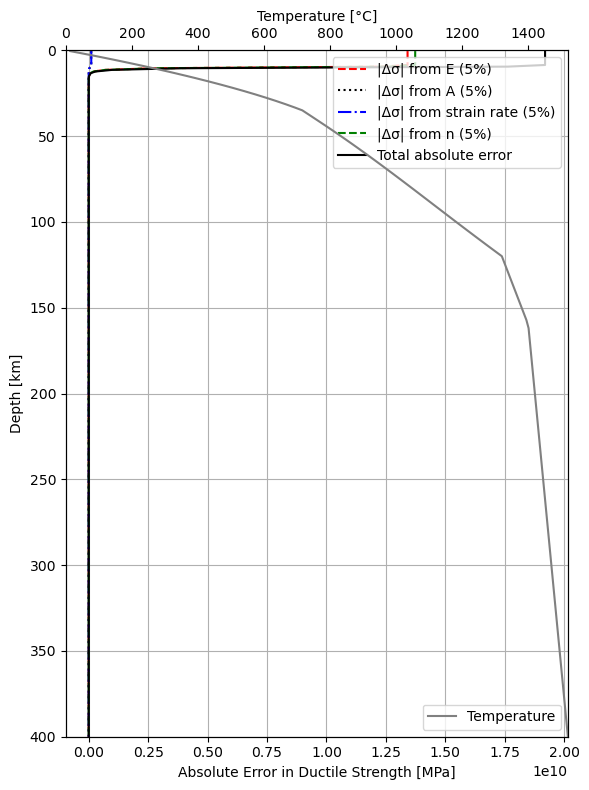

In [252]:
# --- Define symbolic variables ---
T = sym.Symbol('T')  # Temperature [K]
A, E, n, strain_rate, R = sym.symbols('A E n strain_rate R')

# --- Define symbolic expression for dislocation creep ---
sigma_ductile = ((strain_rate / A)** (1 / n) * sym.exp(E / (n* R * T)))   # Pa

# --- Define numerical values ---
A_in = 5.01e-17 # Pa^-n·s^-1
E_in = 5.35e+05 # J/mol
n_in = 3.5
S_r_in = 1e-15  # 1/s
R_in = 8.314  # J/mol·K

# temperature_k and depth_km, temperature_c assumed to be defined
T_min = 515
temp_k_safe = np.clip(temperature_k, T_min, None)

# --- Numerical evaluation function ---
def calc_derivative_geotherm(sigma_expr, T_vals, n_val, A_val, E_val, strain_rate_val, R_val):
    expr_subs = sigma_expr.subs({
        A: A_val,
        E: E_val,
        n: n_val,
        strain_rate: strain_rate_val,
        R: R_val
    }).evalf()
    func = sym.lambdify(T, expr_subs, modules='numpy')
    return func(T_vals)

# --- Convert % error to absolute error ---
def error_percentage2value(value, percentage):
    return value * (percentage / 100)

# --- Base strength profile ---
sigma = calc_derivative_geotherm(sigma_ductile, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# --- Derivatives and error propagation ---
E_error =5
A_error = 5
S_r_error = 5
n_error = 5

# Partial derivatives
Dsigma_DE = sigma_ductile.diff(E)
Dsigma_DA = sigma_ductile.diff(A)
Dsigma_De = sigma_ductile.diff(strain_rate)
Dsigma_Dn = sigma_ductile.diff(n)

# Evaluate partial derivatives numerically
deri_E = calc_derivative_geotherm(Dsigma_DE, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_A = calc_derivative_geotherm(Dsigma_DA, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_S = calc_derivative_geotherm(Dsigma_De, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)
deri_n = calc_derivative_geotherm(Dsigma_Dn, temp_k_safe, n_in, A_in, E_in, S_r_in, R_in)

# Compute absolute errors
error_E = np.abs(deri_E * error_percentage2value(E_in, E_error))
error_A = np.abs(deri_A * error_percentage2value(A_in, A_error))
error_S = np.abs(deri_S * error_percentage2value(S_r_in, S_r_error))
error_n = np.abs(deri_n * error_percentage2value(n_in, n_error))

# Total absolute error in [Pa]
error_total = np.sqrt(error_E**2 + error_A**2 + error_S**2 + error_n**2)

# Convert to MPa
sigma_MPa = sigma / 1e6
error_E_MPa = error_E / 1e6
error_A_MPa = error_A / 1e6
error_S_MPa = error_S / 1e6
error_n_MPa = error_n / 1e6
error_total_MPa = error_total / 1e6

# --- Plot error contributions ---
fig, ax_strength = plt.subplots(figsize=(6, 8))

ax_strength.plot(error_E_MPa, depth_km, 'r--', label='|Δσ| from E (5%)')
ax_strength.plot(error_A_MPa, depth_km, 'k:', label='|Δσ| from A (5%)')
ax_strength.plot(error_S_MPa, depth_km, 'b-.', label='|Δσ| from strain rate (5%)')
ax_strength.plot(error_n_MPa, depth_km, 'g--', label='|Δσ| from n (5%)')
ax_strength.plot(error_total_MPa, depth_km, 'black', label='Total absolute error')

ax_strength.set_xlabel('Absolute Error in Ductile Strength [MPa]')
ax_strength.set_ylabel('Depth [km]')
ax_strength.set_ylim(0, np.max(depth_km))
ax_strength.invert_yaxis()
ax_strength.grid(True)
ax_strength.legend(loc='upper right')

# --- Twin x-axis for temperature ---
ax_temp = ax_strength.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.set_xlim(0, np.max(temperature_c))
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

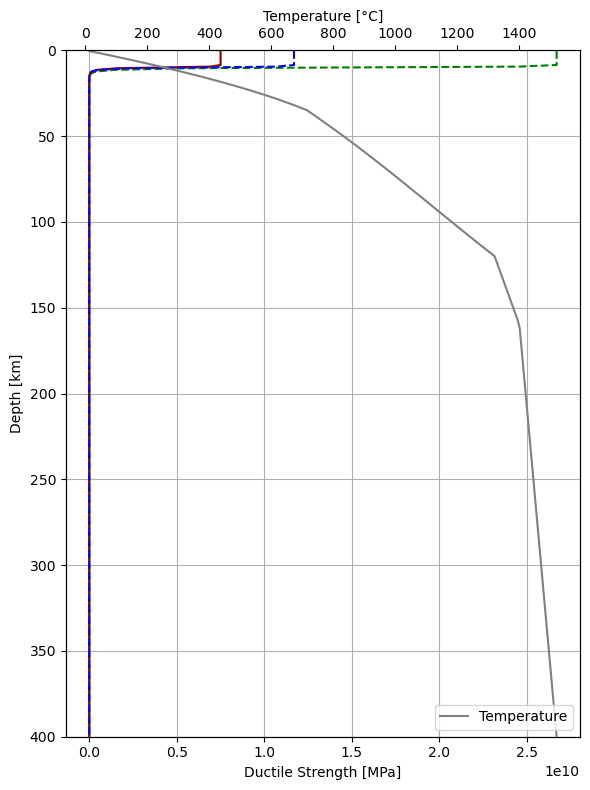

In [254]:
#sigma + delta sigma(absolute error)
sigmad_pos=sigma_ductile_mpa + error_total_MPa
sigmad_neg = np.abs(sigma_ductile_mpa - error_total_MPa )

fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(sigmad_pos, depth_km, 'g--')
ax.plot(sigma_ductile_mpa, depth_km, label=r'$\sigmad$', color='darkred')
ax.plot(sigmad_neg, depth_km, 'b--')
ax.set_xlabel('Ductile Strength [MPa]')
ax.set_ylabel('Depth [km]')
ax.set_ylim(0, 400)
ax.invert_yaxis()
ax.grid(True)

# Add twin x-axis for temperature
ax_temp = ax.twiny()
ax_temp.plot(temperature_c, depth_km, 'gray', label='Temperature')
ax_temp.set_xlabel('Temperature [°C]')
ax_temp.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [256]:
sigma_pos_pe= sigma_pos
sigma_brittle_c_mpa_pe = sigma_brittle_c_mpa
sigma_neg_pe = sigma_neg
sigma_ductile_mpa_pe = sigma_ductile_mpa
sigmad_pos_pe = sigmad_pos
sigmad_neg_pe = sigmad_neg

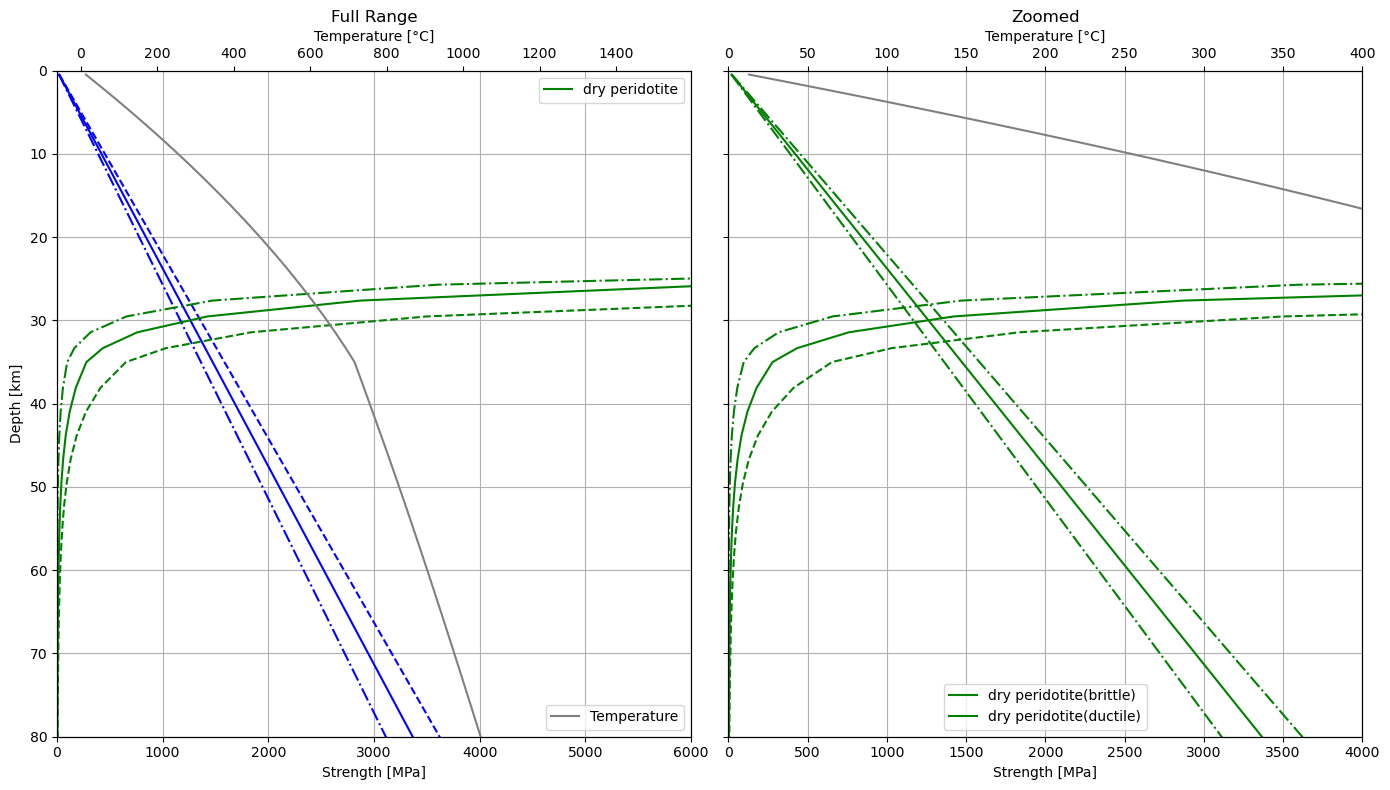

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

ax1.plot(sigma_pos_pe, depth_km, '--',color='blue')
ax1.plot(sigma_brittle_c_mpa_pe, depth_km, color='blue')
ax1.plot(sigma_neg_pe, depth_km, '-.', color='blue' )
ax1.plot(sigma_ductile_mpa_pe, depth_km, 'green', label='dry peridotite')
ax1.plot(sigmad_pos_pe, depth_km,'--',color='green')
ax1.plot(sigmad_neg_pe, depth_km, '-.',color='green')
ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 6000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

ax2.plot(sigma_pos_pe, depth_km, '-.' ,color='green')
ax2.plot(sigma_brittle_c_mpa_pe, depth_km, color='green', label=r'dry peridotite(brittle)')
ax2.plot(sigma_neg_pe, depth_km, '-.', color='green')
ax2.plot(sigma_ductile_mpa_pe, depth_km, 'green', label='dry peridotite(ductile)')
ax2.plot(sigmad_pos_pe, depth_km,'--',color='green')
ax2.plot(sigmad_neg_pe, depth_km, '-.',color='green')


ax2.legend(loc='lower center')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 4000)
ax2.set_ylim(80, 0)
ax2.grid(True)
ax2.set_title('Zoomed')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()


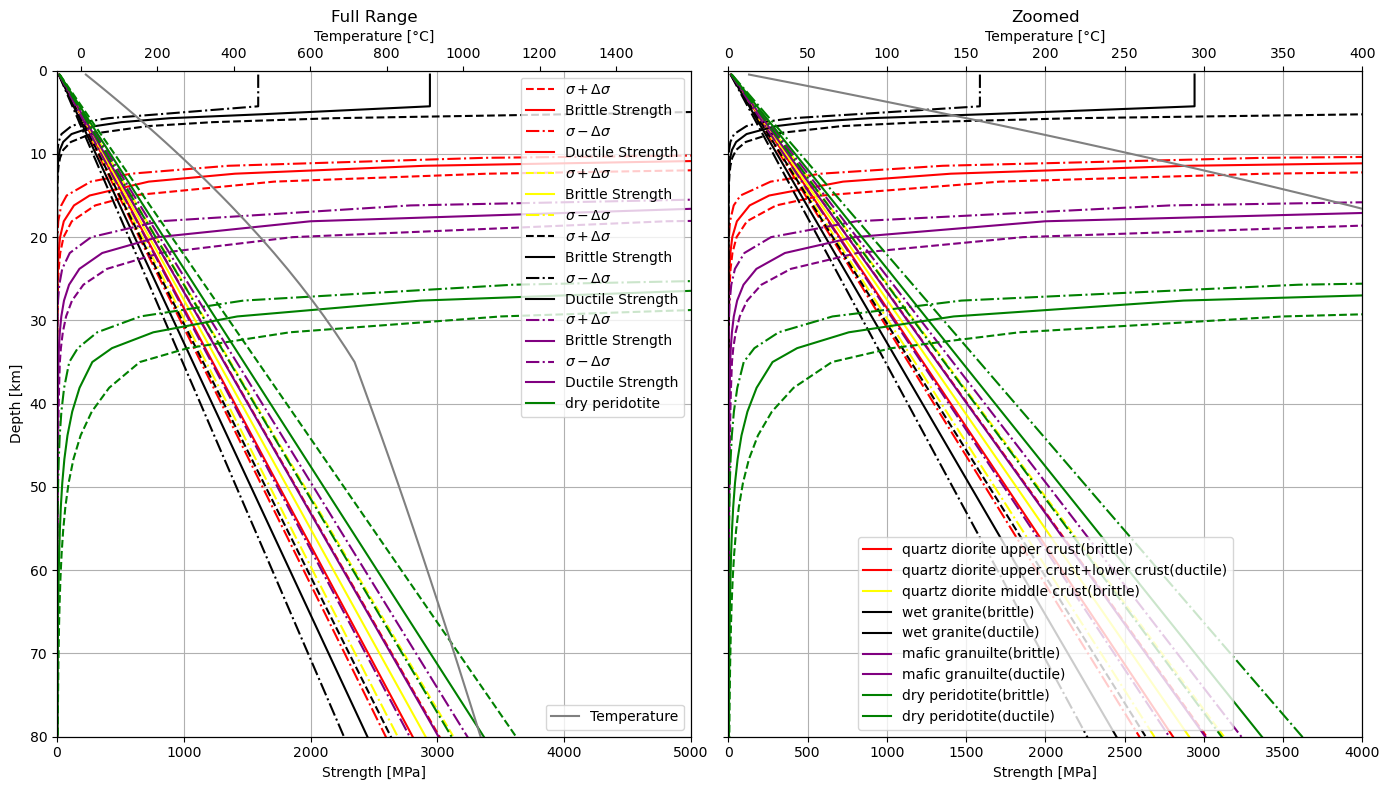

In [272]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

#quartz diorite plot
ax1.plot(sigma_pos_qd, depth_km, '--',color='red', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qd, depth_km, color='red', label=r'Brittle Strength')
ax1.plot(sigma_neg_qd, depth_km, '-.',color = 'red',  label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qd, depth_km, 'red', label='Ductile Strength')
ax1.plot(sigmad_pos_qd, depth_km,'--',color='red')
ax1.plot(sigmad_neg_qd, depth_km, '-.',color='red')
#miidle crust
ax1.plot(sigma_pos_qdm, depth_km, '--',color='yellow', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'Brittle Strength')
ax1.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow',  label=r'$\sigma - \Delta \sigma$')
#wet granite plot
ax1.plot(sigma_pos_wg, depth_km, '--', color='black', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_wg, depth_km, color='black', label=r'Brittle Strength')
ax1.plot(sigma_neg_wg, depth_km, '-.',color='black', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_wg, depth_km, 'black', label='Ductile Strength')
ax1.plot(sigmad_pos_wg, depth_km,'--',color='black')
ax1.plot(sigmad_neg_wg, depth_km, '-.',color='black')
#mafic granuilite
ax1.plot(sigma_pos_qm, depth_km, '-.',color='purple', label=r'$\sigma + \Delta \sigma$')
ax1.plot(sigma_brittle_c_mpa_qm, depth_km, color='purple', label=r'Brittle Strength')
ax1.plot(sigma_neg_qm, depth_km, '-.',color='purple', label=r'$\sigma - \Delta \sigma$')
ax1.plot(sigma_ductile_mpa_qm, depth_km, 'purple', label='Ductile Strength')
ax1.plot(sigmad_pos_qm, depth_km,'--',color='purple')
ax1.plot(sigmad_neg_qm, depth_km, '-.',color='purple')
#dry peridotite
ax1.plot(sigma_pos_pe, depth_km, '--',color='green')
ax1.plot(sigma_brittle_c_mpa_pe, depth_km, color='green')
ax1.plot(sigma_neg_pe, depth_km, '-.', color='green' )
ax1.plot(sigma_ductile_mpa_pe, depth_km, 'green', label='dry peridotite')
ax1.plot(sigmad_pos_pe, depth_km,'--',color='green')
ax1.plot(sigmad_neg_pe, depth_km, '-.',color='green')


ax1.set_xlabel('Strength [MPa]')
ax1.set_ylabel('Depth [km]')
ax1.set_xlim(0, 5000)
ax1.set_ylim(100, 0)  # Invert y-axis
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_title('Full Range')

# --- Zoomed-in subplot ---
#diorite
ax2.plot(sigma_pos_qd, depth_km, '--',color='red')
ax2.plot(sigma_brittle_c_mpa_qd, depth_km, color='red',label='quartz diorite upper crust(brittle)')
ax2.plot(sigma_neg_qd, depth_km, '-.',color = 'red')
ax2.plot(sigma_ductile_mpa_qd, depth_km, 'red', label='quartz diorite upper crust+lower crust(ductile)')
ax2.plot(sigmad_pos_qd, depth_km,'--',color='red')
ax2.plot(sigmad_neg_qd, depth_km, '-.',color='red')

ax2.plot(sigma_pos_qdm, depth_km, '--',color='yellow')
ax2.plot(sigma_brittle_c_mpa_qdm, depth_km, color='yellow', label=r'quartz diorite middle crust(brittle)')
ax2.plot(sigma_neg_qdm, depth_km, '-.',color = 'yellow')
#wet granite
ax2.plot(sigma_pos_wg, depth_km, '--',color='black')
ax2.plot(sigma_brittle_c_mpa_wg, depth_km, color='black', label='wet granite(brittle)')
ax2.plot(sigma_neg_wg, depth_km, '-.',color='black')
ax2.plot(sigma_ductile_mpa_wg, depth_km, 'black',label='wet granite(ductile)')
ax2.plot(sigmad_pos_wg, depth_km, '--',color='black')
ax2.plot(sigmad_neg_wg, depth_km, '-.', color='black')
#granulite
ax2.plot(sigma_pos_qm, depth_km, '-.' ,color='purple')
ax2.plot(sigma_brittle_c_mpa_qm, depth_km, color='purple', label=r'mafic granuilte(brittle)')
ax2.plot(sigma_neg_qm, depth_km, '-.', color='purple')
ax2.plot(sigma_ductile_mpa_qm, depth_km, 'purple', label='mafic granuilte(ductile)')
ax2.plot(sigmad_pos_qm, depth_km,'--',color='purple')
ax2.plot(sigmad_neg_qm, depth_km, '-.',color='purple')
#dry peridotite
ax2.plot(sigma_pos_pe, depth_km, '-.' ,color='green')
ax2.plot(sigma_brittle_c_mpa_pe, depth_km, color='green', label=r'dry peridotite(brittle)')
ax2.plot(sigma_neg_pe, depth_km, '-.', color='green')
ax2.plot(sigma_ductile_mpa_pe, depth_km, 'green', label='dry peridotite(ductile)')
ax2.plot(sigmad_pos_pe, depth_km,'--',color='green')
ax2.plot(sigmad_neg_pe, depth_km, '-.',color='green')


ax2.legend(loc='lower center')
ax2.set_xlabel('Strength [MPa]')
ax2.set_xlim(0, 4000)
ax2.set_ylim(80, 0)
ax2.grid(True)
ax2.set_title('Zoomed')

# --- Add twin x-axes for temperature ---
ax1_temp = ax1.twiny()
ax1_temp.plot(temperature_c, depth_km, color='gray', label='Temperature')
ax1_temp.set_xlabel('Temperature [°C]')
ax1_temp.legend(loc='lower right')

ax2_temp = ax2.twiny()
ax2_temp.plot(temperature_c, depth_km, color='gray')
ax2_temp.set_xlim(0, 400)
ax2_temp.set_xlabel('Temperature [°C]')

plt.tight_layout()
plt.show()